In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
mk=3

##0. Initial 

In [3]:
import scipy.io
import numpy as np
file_name = '/content/drive/MyDrive/2022_SUMMER/Research_Burger/CODE/TranslatePythonCode/'
#file_name = '/content/drive/MyDrive/tamu/BurgerResults/'
mat = scipy.io.loadmat(file_name + 'canadafastfood_resorted.mat')
data = mat['data']#[np.where(mtype_int==1)]
TimePeriod = len(np.unique(data[:,1]))
SamplePath = int(len(data)/TimePeriod)
print(TimePeriod,SamplePath)
print(data[:,0].reshape([TimePeriod,SamplePath]).T)

#% Labeling
MT = len(data)          #% Size of the dataset (M x T = 400 x 35 = 14000).#clusterid = np.int_(data[:,0])      % Unique market ID.
year = np.int_(data[:,1]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
N_aw  = np.int_(data[:,2]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
N_bk  = np.int_(data[:,3]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
N_hvy = np.int_(data[:,4]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
N_mcd = np.int_(data[:,5]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
N_wdy = np.int_(data[:,6]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
lagN_aw  = np.int_(data[:,7]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
lagN_bk  = np.int_(data[:,8]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
lagN_hvy = np.int_(data[:,9]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
lagN_mcd = np.int_(data[:,10]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
lagN_wdy = np.int_(data[:,11]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
fwdN_aw  = np.int_(data[:,12]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
fwdN_bk  = np.int_(data[:,13]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
fwdN_hvy = np.int_(data[:,14]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
fwdN_mcd = np.int_(data[:,15]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
fwdN_wdy = np.int_(data[:,16]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
a_aw  = np.int_(data[:,17]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
a_bk  = np.int_(data[:,18]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
a_hvy = np.int_(data[:,19]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
a_mcd = np.int_(data[:,20]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
a_wdy = np.int_(data[:,21]).reshape([TimePeriod,SamplePath]).T.reshape(-1)
mktfe = data[:,30].reshape([TimePeriod,SamplePath]).T.reshape(-1) #% Market fixed effect estimates (from 130913_alaToivanenWaterson3_Fixedeffect3quantile.csv/dta)
tertile = np.int_(data[:,31]).reshape([TimePeriod,SamplePath]).T.reshape(-1)       #% Market type initial guess (from 130913_alaToivanenWaterson3_Fixedeffect3quantile.csv/dta)

35 400
[[  1.   1.   1. ...   1.   1.   1.]
 [  2.   2.   2. ...   2.   2.   2.]
 [  3.   3.   3. ...   3.   3.   3.]
 ...
 [398. 398. 398. ... 398. 398. 398.]
 [399. 399. 399. ... 399. 399. 399.]
 [400. 400. 400. ... 400. 400. 400.]]


In [4]:
def quantile(x,p):
  x = np.sort(x)
  n = len(x)
  x = np.hstack([x[0], x,x[-1]])
  i = p*n+1.5
  iu = int(np.ceil(i))
  il = int(np.floor(i))
  d = i-il
  qq = x[il-1]*(1-d)+x[iu-1]*d
  return qq

#% Number of own shops (in state space; capped at 3), from the perspective of each firm
Ni_aw = (N_aw <= 3)*N_aw + (N_aw > 3)*3
Ni_bk = (N_bk <= 3)*N_bk + (N_bk > 3)*3
Ni_hvy = (N_hvy <= 3)*N_hvy + (N_hvy > 3)*3
Ni_mcd = (N_mcd <= 3)*N_mcd + (N_mcd > 3)*3
Ni_wdy = (N_wdy <= 3)*N_wdy + (N_wdy > 3)*3
#Ni_other = N_aw + N_bk + N_hvy + N_wdy
#Ni_other = (Ni_other <=3)*Ni_other + (Ni_other>3)*3
#% Number of rival shops (in state space; capped at 3), from the perspective of each firm
Nj_aw = N_bk + N_hvy + N_mcd + N_wdy
Nj_bk = N_aw + N_hvy + N_mcd + N_wdy
Nj_hvy = N_aw + N_bk + N_mcd + N_wdy
Nj_mcd = N_aw + N_bk + N_hvy + N_wdy
Nj_wdy = N_aw + N_bk + N_hvy + N_mcd
Nj_aw = (Nj_aw <= 3)*Nj_aw + (Nj_aw > 3)*3     
Nj_bk = (Nj_bk <= 3)*Nj_bk + (Nj_bk > 3)*3
Nj_hvy = (Nj_hvy <= 3)*Nj_hvy + (Nj_hvy > 3)*3
Nj_mcd = (Nj_mcd <= 3)*Nj_mcd + (Nj_mcd > 3)*3
Nj_wdy = (Nj_wdy <= 3)*Nj_wdy + (Nj_wdy > 3)*3
#Nj_other = (N_mcd <= 3)*N_mcd + (N_mcd > 3)*3
#% Define state variables for each firm
RHS_aw = np.vstack([Ni_aw, Nj_aw]).T
RHS_bk = np.vstack([Ni_bk, Nj_bk]).T   
RHS_hvy = np.vstack([Ni_hvy, Nj_hvy]).T  
RHS_mcd = np.vstack([Ni_mcd, Nj_mcd]).T
RHS_wdy = np.vstack( [Ni_wdy, Nj_wdy]).T
#RHS_other = np.vstack([Ni_other,Nj_other]).T

In [5]:
stateID_aw = Ni_aw*4+Nj_aw#+disc_pop*4**2+disc_val*4**1+disc_inc
stateID_bk = Ni_bk*4+Nj_bk#+disc_pop*4**2+disc_val*4**1+disc_inc
stateID_hvy = Ni_hvy*4+Nj_hvy#+disc_pop*4**2+disc_val*4**1+disc_inc
stateID_mcd = Ni_mcd*4+Nj_mcd#+disc_pop*4**2+disc_val*4**1+disc_inc
stateID_wdy = Ni_wdy*4+Nj_wdy#+disc_pop*4**2+disc_val*4**1+disc_inc
stateID_other = np.hstack([stateID_aw,stateID_bk,stateID_hvy,stateID_wdy])
#stateID_other = Ni_other*4+Nj_other#+disc_pop*4**2+disc_val*4**1+disc_inc


ai_aw = -1*np.int_(a_aw<0) + 0*np.int_(a_aw==0) + 1*np.int_(a_aw>0)+1
ai_bk = -1*np.int_(a_bk<0) + 0*np.int_(a_bk==0) + 1*np.int_(a_bk>0) +1
ai_hvy = -1*np.int_(a_hvy<0) + 0*np.int_(a_hvy==0) + 1*np.int_(a_hvy>0)+1
ai_mcd = -1*np.int_(a_mcd<0) + 0*np.int_(a_mcd==0) + 1*np.int_(a_mcd>0)+1
ai_wdy = -1*np.int_(a_wdy<0) + 0*np.int_(a_wdy==0) + 1*np.int_(a_wdy>0)+1
ai_other = np.hstack([ai_aw,ai_bk,ai_hvy,ai_wdy])
#ai_other = a_aw+a_bk+a_hvy+a_wdy
#ai_other = -1*np.int_(ai_other<0) + 0*np.int_(ai_other==0) + 1*np.int_(ai_other>0)+1

In [6]:
numstates = 2#5 # ni,nj,pop,val,inc
states_full = np.arange(4**numstates)
Ni = states_full//(4**(numstates-1))                       #Number of own outlets: {0,1,2,3+}.
Nj = states_full%(4**(numstates-1))//(4**(numstates-2))    #Number of rival outlets: {0,1,2,3+}.
print(np.sum(np.abs(Ni*4+Nj-states_full)))
states = np.stack([Ni,Nj],axis=1)

0


In [7]:
import pandas as pd
filename = '/content/drive/MyDrive/2022_SUMMER/Research_Burger/Picture/'#file_name#
data_extra = pd.read_csv(filename+'ExtraData.csv')
print(data_extra.columns)
obser = 2
# gdp = data_extra['Inflation_Rate']#['disc_inf']#['disc_une']#['Inflation_Rate']#['GDP_Grwoth_Rate']#['Unemployment_Rate']#
gdp = data_extra['InflationRateLag_wb']#['disc_inf']#['disc_une']#['disc_gdp']
gdp50 = quantile(gdp,0.5)
print(gdp50)
disc_gdp = np.int_(gdp <= gdp50)#0)#<gdp50)#)#np.int_(gdp <0)#
trans_gdp = np.zeros([obser,obser],dtype=int)

for i in range(34):
  trans_gdp[disc_gdp[i],disc_gdp[i+1]] +=1
print(trans_gdp)
trans_gdp = trans_gdp/np.kron(np.ones([1,obser]),np.sum(trans_gdp,axis=1).reshape([-1,1]))
print(trans_gdp)
disc_gdp = (np.repeat(disc_gdp[0:TimePeriod],SamplePath).reshape([TimePeriod,SamplePath]).T).reshape(-1)

Index(['year', 'GDP_Grwoth_Rate', 'Inflation_Rate', 'Unemployment_Rate', 'GDP',
       'Government Budget', 'Government Debt', 'Medical Doctors',
       'Tip1_GDP_Grwoth_Rate', 'Tip2_GDP_Growth_Yearly',
       'Tip3_GDP_Growth_Annualy', 'Tip4_GDP_Growth_AVGAnnualy', 'Unnamed: 12',
       'Unemployment_Rate_GrowthRate', 'GDP_Growth_Yearly',
       'Medical_Doctors_Growth_Yearly', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'disc_gdp', 'disc_une', 'disc_inf', 'InflationRate_wb',
       'InflationRateLag_wb', 'InflationRateLag2_wb', 'IncInflationRate_wb',
       'IncInflationRateLag_wb', 'IncInflationRateLag2_wb', 'UneRate_wb',
       'UneRateLag_wb', 'UneRateLag2_wb', 'IncUneRate_wb', 'IncUneRateLag_wb',
       'IncUneRateLag2_wb', 'RealGDP_wb', 'GrowthRealGDP_wb', 'disc_InfInc',
       'disc_InfIncLag', 'disc_InfIncLag2', 'disc_UneInc', 'disc_UneIncLag',
       'disc_UneIncLag2', 'disc_RealGdpGrowth'],
      dtype='object')
4.1114999999999995
[[15  3]
 [ 3 13]]
[[0.83333333 0.16

#Partial

##1. Global transtion F_Ni, F_dz1,F_dz2,F_dz3

In [8]:
I = 2 #MCD and Other homogenous
J = 3 #Action: 0,1,2
NS = 4**(numstates)
NX = 100
NZ = obser

F_Ni = np.zeros([I,J,NX,NS,NS])#;
#for i in range(NX): 
F_Ni[0,0] = np.kron(np.array([[1]*4+[0]*4 + [0] *4+[0]*4]*4 +\
                          [[1]*4+[0]*4 + [0] *4+[0]*4]*4 + \
                          [[0]*4+[1]*4 + [0] *4+[0]*4]*4 + \
                          [[0]*4+[0]*4 + [1] *4+[0]*4]*4 ),np.ones([NX,1,1]))
F_Ni[0,1] =np.kron(np.array([[1]*4+[0]*4 + [0] *4+[0]*4]*4 +\
                          [[0]*4+[1]*4 + [0] *4+[0]*4]*4 + \
                          [[0]*4+[0]*4 + [1] *4+[0]*4]*4 + \
                          [[0]*4+[0]*4 + [0] *4+[1]*4]*4 ),np.ones([NX,1,1]))
F_Ni[0,2] = np.kron(np.array([[0]*4+[1]*4 + [0] *4+[0]*4]*4 +\
                          [[0]*4+[0]*4 + [1] *4+[0]*4]*4 + \
                          [[0]*4+[0]*4 + [0] *4+[1]*4]*4 + \
                          [[0]*4+[0]*4 + [0] *4+[1]*4]*4 ),np.ones([NX,1,1]))
F_Ni[1] = F_Ni[0]

##2. Dynamix and SigmaLambda

In [9]:
import itertools
dim_hstate = 2
dim_observe = obser
def Dynamic(theta23):
  trans_val = theta23[0:2]
  obser_val = theta23[2:]

  trans = np.zeros([dim_hstate,dim_hstate]) #s_t^h,s_{t+1}^h
  trans[:,0] = trans_val
  trans[:,1] = 1-trans[:,0]
  obser = np.zeros([dim_hstate,dim_observe])
  obser[:,0] = [obser_val,1-obser_val]
  #obser[:,0] = obser_val
  obser[:,1] = 1-obser[:,0]
  return trans,obser
#print(Dynamic(np.array([0.95, 0.05]+ [0.125, 0.125])))#,0.125]+[0.1])))#,0.1,0.1])))  

def SigmaLambda(theta23,z_old = None,x_old=None,T=None,num_discrete = NX):
  trans,obser = Dynamic(theta23)
  if T==None: #generate function for Q function
    x_old =  np.linspace(0,1,num=num_discrete)
    x_new = np.zeros([num_discrete,dim_observe]) #x_old,z_old,z_new
    sigma = np.zeros([num_discrete,dim_observe])

    for z in range(dim_observe):
      #for z_prime in range(dim_observe):
        x_temp = (x_old*trans[0,0] + (1-x_old) * trans[1,0])*obser[0,z]#,z_prime]
        sigma[:,z] = x_temp + (x_old*trans[0,1] + (1-x_old) * trans[1,1])*obser[1,z]#,z_prime]
        sigma_nonzero = np.where(sigma[:,z]!=0)
        x_new[:,z][sigma_nonzero] = x_temp[sigma_nonzero]/sigma[:,z][sigma_nonzero]
  elif T==1:
    x_temp = (x_old*trans[0,0]+(1-x_old)*trans[1,0])*obser[0,z_old]
    sigma = x_temp + (x_old*trans[0,1]+(1-x_old)*trans[1,1])*obser[1,z_old]
    #sigma_nonzero = np.where(sigma!=0)
    x_new = x_temp/sigma#[sigma_nonzero]/sigma[sigma_nonzero]
  else: #generate whole blief in recover process
    x_new = np.zeros([T,len(x_old)])
    sigma = np.zeros([T-1,len(x_old)])
    x_new[0] = x_old
    for t in range(T-1):
      #z = z_old[t,:]
      z_prime = z_old[t+1,:]
      x_temp = (x_new[t]*trans[0,0]+(1-x_new[t])*trans[1,0])*obser[0,z_prime]
      sigma[t] = x_temp + (x_new[t]*trans[0,1]+(1-x_new[t])*trans[1,1])*obser[1,z_prime]
      sigma_nonzero = np.where(sigma[t]!=0)
      x_new[t+1][sigma_nonzero] = x_temp[sigma_nonzero]/sigma[t][sigma_nonzero]

  belief_f = np.floor(x_new*(num_discrete-1))/(num_discrete-1)
  belief_c = np.ceil(x_new*(num_discrete-1))/(num_discrete-1)
  iterpolate = np.zeros(belief_f.shape)
  iterpolate[np.where((belief_f-belief_c)!=0)] = (x_new-belief_c)[np.where((belief_f-belief_c)!=0)]/(belief_f-belief_c)[np.where((belief_f-belief_c)!=0)]      

  return sigma,x_new,[iterpolate,np.int_(belief_f*(num_discrete-1)),np.int_(belief_c*(num_discrete-1))]

# theta23 = np.array([0.95, 0.05,0.125, 0.125])#,0.125]+[0.1])#,0.1,0.1])
# sigma,_,(iterp,iterf,iterc) = SigmaLambda(theta23)

## 3. Generate P(nj|policy)

In [10]:
F_fix = F_Ni
# % Calculate F from P (& global transition matrices F_Ni, F_dz1, F_dz2) 
import time
def updateF(P):
  #% For a given combination of (Ni, dz1, dz2, mtype), make the state indexes (x, x0, x1, x2, x3)
  #% Beliefs: mapping from today's state (Ni,Nj,dz1,dz2) to tomorrow's Nj = {0,1,2,3}
  fnj_mcd = np.zeros([NX,NS,4])#;      % McDonald's belief
  fnj_other = np.zeros([NX,NS,4])#;    % Other 4 chains beliefs

  nj = 0#;         % If today's # of rivals = 0
  x =  (4)*Ni + (1)*nj #+ (4**2)*dz1 + 4*dz2+dz3#;  % index of today's own state
  x0 = (4)*0 + (1)*Ni #+ (4**2)*dz1 + 4*dz2+dz3#;  % index of today's state for rivals with 0 shops

  fnj_mcd[:,x,0] = P[1,1][:,x0]**4#;                               % Prob(Nj'= 0) from McD's perspective
  fnj_mcd[:,x,1] = 4 * P[1,2][:,x0] * (P[1,1][:,x0]**3)#;       % Prob(Nj'= 1) from McD's perspective
  fnj_mcd[:,x,2] = 6 * (P[1,2][:,x0]**2) * (P[1,1][:,x0]**2)#;   % Prob(Nj'= 2) from McD's perspective
  fnj_mcd[:,x,3] = 4 * (P[1,2][:,x0]**3) * P[1,1][:,x0]#;       % Prob(Nj'= 3) from McD's perspective
  
  fnj_other[:,x,0] = P[0,1][:,x0] * (P[1,1][:,x0]**3)#;         % Prob(Nj'= 0) etc. from Others' perspectives
  fnj_other[:,x,1] = P[0,2][:,x0] * (P[1,1][:,x0]**3) + P[0,1][:,x0] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)#;  
  fnj_other[:,x,2] = P[0,2][:,x0] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2) + P[0,1][:,x0] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0]
  fnj_other[:,x,3] = P[0,2][:,x0] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0] + P[0,1][:,x0] * (P[1,2][:,x0]**3)

  
  nj = 1#;         % If today's # of rivals = 1                               
  x =  (4)*Ni + (1)*nj #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4)*0 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 =  (4)*1 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  
  fnj_mcd[:,x,0] = P[1,0][:,x1] * (P[1,1][:,x0]**3)#;
  fnj_mcd[:,x,1] = P[1,1][:,x1] * (P[1,1][:,x0]**3)#;
  fnj_mcd[:,x,2] = P[1,2][:,x1] * (P[1,1][:,x0]**3) + P[1,1][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)#;
  fnj_mcd[:,x,3] = P[1,2][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2) + P[1,1][:,x1] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0]
  
  fnj_other[:,x,0] = .5 * (P[0,0][:,x1] * P[1,1][:,x0]**3) + .5 * (P[0,1][:,x0] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,1] = .5 * (P[0,1][:,x1] * P[1,1][:,x0]**3) + .5 * (P[0,1][:,x0] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .5 * (P[0,2][:,x1] * (P[1,1][:,x0]**3) + P[0,1][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2))+\
                              .5 * (P[0,2][:,x0] * P[1,1][:,x1] * (P[1,1][:,x0]**2) +\
                        P[0,1][:,x0] * (P[1,2][:,x1] * (P[1,1][:,x0]**2) + P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]))
  fnj_other[:,x,3] = .5 * (P[0,2][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)\
                        + P[0,1][:,x1] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0])\
                        + .5 * (P[0,2][:,x0] * P[1,2][:,x1] * (P[1,1][:,x0]**2)\
                      + P[0,2][:,x0] * P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]\
                      + P[0,1][:,x0] * P[1,2][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]\
                      + P[0,1][:,x0] * P[1,1][:,x1] * (P[1,2][:,x0]**2))

  nj = 2#;         % If today's # of rivals = 2
  x = (4)*Ni + (1)*nj #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4)*0 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 =  (4)*1 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  x2 = (4)*2 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 2 shops
  
  fnj_mcd[:,x,0] = (P[1,0][:,x1]**2) * (P[1,1][:,x0]**2)
  fnj_mcd[:,x,1] = (1/3) * (P[1,0][:,x2] * (P[1,1][:,x0]**3)) + (2/3) * (P[1,0][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,2] = (1/3) * (P[1,1][:,x2] * (P[1,1][:,x0]**3)) + (2/3) * ((P[1,1][:,x1]**2) * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,3] = (1/3) * (P[1,2][:,x2] * (P[1,1][:,x0]**3)  + (P[1,1][:,x2] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)))
  
  fnj_other[:,x,0] = .5 * 0 + .5 * (P[0,0][:,x1] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,1] = .5 * (P[0,0][:,x2] * (P[1,1][:,x0]**3))\
      + .5 * (P[0,0][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .5 * (P[0,1][:,x2] * (P[1,1][:,x0]**3))\
      + .5 * (P[0,1][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,3] = .5 * (P[0,2][:,x2] * (P[1,1][:,x0]**3)\
      + P[0,1][:,x2] * 3 * P[1,2][:,x0] * P[1,1][:,x0])\
      + .5 * (P[0,2][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,2][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0])
  
  nj = 3#;         % If today's # of rivals = 3
  x = (4)*Ni + (1)*nj #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4)*0 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 =  (4)*1 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  x2 =  (4)*2 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  x3 = (4)*3 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 3 shops
  
  fnj_mcd[:,x,0] = (2/3) * (P[1,0][:,x1]**3) * P[1,1][:,x0]
  fnj_mcd[:,x,1] = (2/3) * (P[1,0][:,x1]**2) * P[1,1][:,x1] + (1/3) * P[1,0][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2)
  fnj_mcd[:,x,2] = (2/3) * P[1,0][:,x1] * (P[1,1][:,x1]**2) + (1/3) * (P[1,0][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[1,1][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,3] = (2/3) * (P[1,1][:,x1]**3) * P[1,1][:,x0] + (1/3) * P[1,1][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)
  
  fnj_other[:,x,0] = .25 * (P[0,0][:,x1] * (P[1,0][:,x1]**2) * P[1,1][:,x0])
  fnj_other[:,x,1] = .25 * 0 + .25 * (P[0,0][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,0][:,x1] * 2 * P[1,0][:,x1] * P[1,1][:,x1] * P[1,1][:,x0]\
      + P[0,1][:,x1] * (P[1,0][:,x1]**2) * P[1,1][:,x0])\
      + .25 * (P[0,0][:,x1] * P[1,0][:,x2] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .25 * (P[0,0][:,x3] * (P[1,1][:,x0]**3))\
      + .25 * (P[0,0][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,0][:,x1] * (P[1,1][:,x1]**2) * P[1,1][:,x0]\
      + P[0,1][:,x1] * 2 * P[1,0][:,x1] * P[1,1][:,x1] * P[1,1][:,x0])\
      + .25 * (P[0,0][:,x1] * P[1,1][:,x2] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,0][:,x2] * (P[1,1][:,x0]**2))
  fnj_other[:,x,3] = .25 * (P[0,1][:,x3] * (P[1,1][:,x0]**3))\
      + .25 * (P[0,1][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,1][:,x1] * (P[1,1][:,x1]**2) * P[1,1][:,x0])\
      + .25 * (P[0,1][:,x1] * P[1,1][:,x2] * (P[1,1][:,x0]**2))

  F_Nj = np.ones([I,J,NX,NS,NS])
  Denom_mcd = np.matmul(fnj_mcd,np.ones([NX,4,4]))#np.kron(np.reshape(np.sum(fnj_mcd,axis=2),[NX,-1,1]),np.ones([1,1,4]))#;         % Sum of each row
  fnj_mcd = fnj_mcd / Denom_mcd#;                 % Make sure each row sums up to 1
  fnj_mcd[np.isnan(fnj_mcd)] = 0#;                    % Replace NaN with 0
  F_Nj[0,0] = fnj_mcd[:,:,Nj]

  Denom_other = np.matmul(fnj_other,np.ones([NX,4,4]))#np.kron(np.reshape(np.sum(fnj_other,axis=2),[NX,-1,1]),np.ones([1,1,4]))#;             % Sum of each row
  fnj_other = fnj_other / Denom_other#;                   % Make sure each row sums up to 1
  fnj_other[np.isnan(fnj_other)] = 0#;                        % Replace NaN with 0
  F_Nj[1,0] = fnj_other[:,:,Nj]
  #F_Nj[2:5,j,:,:] = np.stack([F_Nj[1,j,:,:] for copy in range(3)],axis=0)#;    % Other 4 chains are symmetric

  for j in range(1,J):    
      F_Nj[:,j] = F_Nj[:,0]    
  return F_Nj*F_fix

# P_new = 1/J*np.ones([I,J,NX,NS])#softmax(np.arange(I*J*NS).reshape([I,J,NS]),axis=1)
# F_new = updateF(P_new.copy())
# #np.sum(F_new!=0)
# print(F_new.shape)

##4.Value Iteration

In [11]:
from scipy.special import logsumexp
from scipy.special import softmax

def updatePi(Q):
  P = np.zeros([I,J,NX,NS])#; player, action, states, Market Type
  P[0] = softmax(Q[0],axis=0)
  P[1] = softmax(Q[1],axis=0)
  P[np.isnan(P)] = 0#;
  return P

def updateQ(thetaS,Q,F,sigmaP,iterpP,iterf,iterc,Q_new,beta = 0.9):

  gamma = 0.5772
    
  v_mcd = np.zeros([J,NX,obser,NS])
  v_other = np.zeros([J,NX,obser,NS])

  v_mcd= iterpP*Q[0][:,iterf,:] + (1-iterpP)*Q[0][:,iterc,:] # Agent, action,NX_new(NX_old,NZ_old,NZ_new), NZ_new,NS_new
  v_other = iterpP*Q[1][:,iterf,:] + (1-iterpP)*Q[1][:,iterc,:]
  #v_mcd = np.stack([iterpP*Q[0,j][iterf]+(1-iterpP)*Q[0,j][iterc] for j in range(J)],axis=0)
  #v_other = np.stack([iterpP*Q[1,j][iterf]+(1-iterpP)*Q[1,j][iterc] for j in range(J)],axis=0)
  v_mcd = gamma + logsumexp(v_mcd,axis=0) #x_old,z_old,z_new,NS_new
  v_other = gamma + logsumexp(v_other,axis=0) #x_old,z_old,z_new,NS_new
  v_mcd = np.sum(sigmaP*v_mcd,axis=1).reshape([1,NX,NS,1]) #x_old,z_old,NS_new
  v_other = np.sum(sigmaP*v_other,axis=1).reshape([1,NX,NS,1])
  v_mcd = np.kron(v_mcd,np.ones([J,1,1,1])) #a_old,x_old,NZ_old,NS_new,1
  v_other = np.kron(v_other,np.ones([J,1,1,1])) #a_old,x_old,NZ_old,NS_new,1

  v_temp_mcd = np.matmul(F[0],v_mcd)[:,:,:,0] # action_old,x_old,nz_old, ns_old (ns_new \times ns_new)
  v_temp_other = np.matmul(F[1],v_other)[:,:,:,0] 

  Q_new[0] = Q_new[0] + beta*(v_temp_mcd) 
  Q_new[1] = Q_new[1] + beta*(v_temp_other)
  return Q_new

#theta23 = np.array([0.95, 0.05]+ [0.9])#, 0.1,0.9,0.1])#,0.1,0.1])
# sigma,_,(iterp,iterf,iterc) = SigmaLambda(theta23)
# sigmaP = np.kron(sigma.reshape([NX,obser,1]),np.ones([1,1,NS]))
# iterpP = np.kron(iterp.reshape([1,NX,obser,1]),np.ones([J,1,1,NS]))


import time

def ValueIteration(thetaS,sigmaP,iterpP,iterf,iterc,error = 5e-3,beta = 0.9):
  Pi0 = 1/3*np.ones([I,J,NX,NS])
  F0= updateF(Pi0)
  Q0 = np.zeros([I,J,NX,NS])
  Pi_old = Pi0
  F_old = F0
  Q_old = Q0

  x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([thetaS[2],thetaS[3],thetaS[4]]),[-1,1])
  thetaS_other = np.reshape(np.array([thetaS[7],thetaS[8],thetaS[9]]),[-1,1])
  Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, -1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, 0* np.ones(NS)],axis=1).dot(thetaS_mcd)

  R_new[0,2] =   np.ones([NX,1]).dot(r_mcd_a2.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,1] =   np.ones([NX,1]).dot(r_mcd_a1.T)+\
                thetaS[0]*    x_old.dot(Ni_temp)+\
                thetaS[1]*(1-x_old).dot(Ni_temp)
  R_new[0,0] = R_new[0,1,:,:].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj, -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj, 0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2] =  np.ones([NX,1]).dot(r_other_a2.T)+\
                thetaS[5]*    x_old.dot(Ni_temp)+\
                thetaS[6]*(1-x_old).dot(Ni_temp)
  R_new[1,1] =  np.ones([NX,1]).dot(r_other_a1.T)+\
                thetaS[5]*    x_old.dot(Ni_temp)+\
                thetaS[6]*(1-x_old).dot(Ni_temp)
  R_new[1,0] = R_new[1,1].copy()
  error1 = np.inf
  for iter in range(1000):
    # time_start = time.time()
    Q_new = updateQ(thetaS,Q_old,F_old,sigmaP,iterpP,iterf,iterc,Q_new = R_new.copy(),beta=beta) #I, J, NS
    Pi_new = updatePi(Q_new)#I,J,NS
    #time_start1 = time.time()
    #print(time_start1-time_start)
    F_new = updateF(Pi_new) # I, J, NS,NS
    #print(time.time()-time_start1)
    if iter>0:
      error1 = np.max(np.abs(Q_new-Q_old))/np.max(np.abs(Q_old))
    # error2 = np.max(np.abs(Pi_new-Pi_old))/np.max(np.abs(Pi_old))
    # error3 = np.max(np.abs(F_new-F_old))/np.max(np.abs(F_old))
    # print('iteration {} --> e1:{:.4f}({:.4f}), e2:{:.4f}({:.4f}), e3:{:.4f}({:.4f}), time:{}'.format(iter,error1,np.max(np.abs(Q_old)),error2,np.max(np.abs(Pi_old)),error3,np.max(np.abs(F_old)),time.time()-time_start))
    # #print('iteration {} --> e1:{},time:{}'.format(iter,error1,time.time()-time_start))

    if error1<error :#and error2<error and error3<error:
      #print('iteration {} --> e1:{},e2:{},e3:{}'.format(iter,error1,error2,error3))
      break
    Q_old = Q_new.copy()
    Pi_old = Pi_new.copy()
    F_old = F_new.copy()
  return Q_new, Pi_new,F_new

# thetaS = np.array([3.9488,2.4672,-2.5972,-0.4203,12.5872,
#                    1.3230,1.1637,-0.5400,-0.1731,7.6820])
# #thetaS = np.zeros(5*2)
# Q_new, Pi_new,F_new = ValueIteration(thetaS,sigmaP,iterpP,iterf,iterc)

##5. log-likelihood (Partial)

In [12]:
import pickle
#with open(file_name+'/transition.txt','rb') as fp:

with open('/content/drive/MyDrive/2022_SUMMER/Research_Burger/Picture/transition.txt','rb') as fp:
  haha = pickle.load(fp)
print(haha)
for i in [2012,2021]:
  for j in ['year','quater','month']:
    print(i,j,haha[i][j][0,0]/np.sum(haha[i][j][0]),haha[i][j][1,0]/np.sum(haha[i][j][1]))
    haha[i][j] = np.array([haha[i][j][0,0]/np.sum(haha[i][j][0]),haha[i][j][1,0]/np.sum(haha[i][j][1])])
haha

{2012: {'year': array([[ 5,  3],
       [ 3, 23]]), 'quater': array([[ 18,   4],
       [  4, 113]]), 'month': array([[ 49,   4],
       [  4, 362]])}, 2021: {'year': array([[ 4,  3],
       [ 3, 24]]), 'quater': array([[ 17,   3],
       [  3, 116]]), 'month': array([[ 47,   3],
       [  3, 366]])}}
2012 year 0.625 0.11538461538461539
2012 quater 0.8181818181818182 0.03418803418803419
2012 month 0.9245283018867925 0.01092896174863388
2021 year 0.5714285714285714 0.1111111111111111
2021 quater 0.85 0.025210084033613446
2021 month 0.94 0.008130081300813009


{2012: {'year': array([0.625     , 0.11538462]),
  'quater': array([0.81818182, 0.03418803]),
  'month': array([0.9245283 , 0.01092896])},
 2021: {'year': array([0.57142857, 0.11111111]),
  'quater': array([0.85      , 0.02521008]),
  'month': array([0.94      , 0.00813008])}}

In [13]:
tertile_other = tertile#np.hstack([tertile,tertile,tertile,tertile])

In [14]:
disc_gdp_other = disc_gdp#np.hstack([disc_gdp for i in range(4)])
disc_gdp_mcd = disc_gdp.copy()
z_data = disc_gdp[tertile==mk].reshape([-1,TimePeriod]).T
x_data = (1/obser)*np.ones(z_data.shape[1])*0 +1

In [15]:
#theta23,trans_gdp

In [16]:
#x_data =np.random.random(z_data.shape[1])#0*(1/obser)*np.ones(z_data.shape[1])# # 1368.8702
print(x_data)
from scipy.optimize import minimize
lower_bound = 1e-4
# a1 = None#0.8993 # None#
# a2 = 0.008  #None#
def func1(theta23):
  # if a1!=None:
  #   theta23 = np.hstack([[a1,a2],theta23])
  # theta23[0],theta23[1] = 0.8993,0.008
  sigma_val,_,_ = SigmaLambda(theta23,z_old = z_data,x_old=x_data,T=TimePeriod)
  #sigma_val[np.isnan(sigma_val)] = 0
  res = -np.sum(np.log(sigma_val[np.where(sigma_val!=0)]))

  print(theta23,res)
  return res #/(5*MT)

from scipy import optimize
a1 = 0.8993
a2 = 0.008
init_x0 = np.array([0.93920617, 0.0081    ,0.9999])#,0.0001])#, 1-2*lower_bound, 2*lower_bound])#theta23
#rranges = [(lower_bound,1-lower_bound)]*len(init_x0)#,(lower_bound,0.5-lower_bound)]# *2
rranges = [(a1-lower_bound,a1),(a2,a2+lower_bound),
#rranges = [(2*lower_bound-lower_bound,1-lower_bound),(2*lower_bound-lower_bound,1-lower_bound),
           (0.5+lower_bound,1-lower_bound)]#,(0+lower_bound,1-lower_bound)]#,
           #(0+lower_bound,1-lower_bound),(0+lower_bound,1-lower_bound)]

print('start from:',init_x0)
cons=[{'type':'ineq', 'fun': lambda x: 1-x[2]-x[3]-x[4]},
      {'type':'ineq', 'fun': lambda x: 1-x[5]-x[6]-x[7]},
      {'type':'ineq', 'fun': lambda x: x[3]-x[6]}]
res1 = minimize(func1,init_x0,bounds = rranges)#,constraints=cons)#,options={'maxiter':1000},tol=1e-5)
print(res1,res1.fun)#*5*MT)
print(Dynamic(res1.x))
# rranges = [(0.5+lower_bound,1-lower_bound),(0+lower_bound,0.5-lower_bound),
#            (0.5+lower_bound,1-lower_bound),(0.5+lower_bound,1-lower_bound)]
# resbrute = optimize.brute(func1, rranges, finish=None,Ns=10)
# print(resbrute,func1(resbrute))
trans_est = np.zeros([2,2])
trans_est[:,0] = res1.x[0:2]
trans_est[:,1] = 1-trans_est[:,0]
#print(trans_est)
pi_distEst = trans_est.copy()
for i in range(200):
  pi_distEst = pi_distEst.dot(trans_est)
print('----->',pi_distEst[0])
# [[0.94       0.06      ]
#  [0.00813008 0.99186992]]
# -----> [0.11933235 0.88066765]
#       fun: 1589.872636160479
#  hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
#       jac: array([-1.56897148e+03,  1.11835193e+03, -4.54747349e-05])
#   message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
#      nfev: 48
#       nit: 8
#      njev: 12
#    status: 0
#   success: True
#         x: array([0.8993    , 0.008     , 0.93759445]) 1589.872636160479
# (array([[0.8993, 0.1007],
#        [0.008 , 0.992 ]]), array([[0.93759445, 0.06240555],
#        [0.06240555, 0.93759445]]))
# -----> [0.07359706 0.92640294]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
start from: [0.93920617 0.0081     0.9999    ]
[0.8993 0.0081 0.9999] 2412.120932406043
[0.89929999 0.0081     0.9999    ] 2412.1209193618192
[0.8993     0.00809999 0.9999    ] 2412.1212137484054
[0.8993     0.0081     0.99989999] 2412.1185698515806
[0.8992 0.0081 0.5001] 3134.1594896352453
[0.89920001 0.0081     0.5001    ] 3134.159489623336
[0.8992     0.00809999 0.5001    ] 3134.159489603693
[0.8992     0.0081     0.50010001] 3134.1594644089223
[0.89926689 0.0081     0.83443717] 1785.31504962611
[0.8992669  0.0081     0.83443717] 1785.3150341433322
[0.89926689 0.00809999 0.83443717] 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if sys.path[0] == '':


In [17]:
z_data.T.reshape(-1)

array([1, 0, 0, ..., 1, 1, 1])

In [18]:
tertile_other = np.hstack([tertile,tertile,tertile,tertile])
norm_thetaS = 1
sigma1,_,(iterp1,iterf1,iterc1) = SigmaLambda(res1.x)
sigmaP1 = np.kron(sigma1.reshape([NX,obser,1]),np.ones([1,1,NS]))
iterpP1 = np.kron(iterp1.reshape([1,NX,obser,1]),np.ones([J,1,1,NS]))

_,_,(iterp2,iterf2,iterc2) = SigmaLambda(res1.x,z_old = z_data,x_old=x_data,T=TimePeriod)
#x_blief = (x_blief.T).reshape(-1)
iterp2 = (iterp2.T).reshape(-1)
iterf2 = (iterf2.T).reshape(-1)
iterc2 = (iterc2.T).reshape(-1)
iterp2_other = np.hstack([iterp2 for i in range(4)])
iterf2_other = np.hstack([iterf2 for i in range(4)])
iterc2_other = np.hstack([iterc2 for i in range(4)])
z_data_old = z_data.T.reshape(-1)
def func(thetaS):
  _, Pi_new,_ = ValueIteration(thetaS*norm_thetaS,sigmaP=sigmaP1,iterpP=iterpP1,iterf=iterf1,iterc=iterc1)
  #print(np.unique(a_mcd))
  res = -np.sum(np.log(  iterp2 *Pi_new[0,ai_mcd[tertile==mk],iterf2,stateID_mcd[tertile==mk]]+\
                      (1-iterp2)*Pi_new[0,ai_mcd[tertile==mk],iterc2,stateID_mcd[tertile==mk]]))
  res = res -np.sum(np.log(  iterp2_other *Pi_new[1,ai_other[tertile_other==mk],iterf2_other,stateID_other[tertile_other==mk]]+\
                          (1-iterp2_other)*Pi_new[1,ai_other[tertile_other==mk],iterc2_other,stateID_other[tertile_other==mk]]))
  print(thetaS*norm_thetaS,res)
  return res/5/MT
from scipy.optimize import minimize

# thetaS = np.array([(3.9488+2.4672)/2,-2.5972,-2.5972,-0.4203,0.0931,0.1513,0.0730,12.5872,
#                    (1.3230+1.1637)/2,-0.5400,-0.5400,-0.1731,0.0596,0.0413,0.0116,7.6820])

#thetaS = np.zeros((7+1)*2)
thetaS = np.array([ 1.79607692e+00,  1.95191105e+00, -3.74040781e-01, -2.98514987e-02,
        9.00501233e+00,  1.04687301e+00,  1.20239889e+00, -2.17774668e-01,
       -1.76373972e-03,  5.30138302e+00])/norm_thetaS
# 0*np.array([2.4672,3.9488,-2.5972,-0.4203,12.5872,
#                    1.1637,1.3230,-0.5400,-0.1731,7.6820])/norm_thetaS
# thetaS = np.array([3.15545706,  4.13433701, -1.75734477, -0.47162658, 13.16363288,
#         1.29946389,  1.68363601, -0.50979805, -0.1673329 ,  6.17395639])/norm_thetaS
print('start from:',thetaS*norm_thetaS )
res22 = minimize(func,thetaS,options={'maxiter':4000},tol=1e-4)
print(res22)
print(res22.x*norm_thetaS,res22.fun*5*MT) # 28min

#       fun: 0.08975854678916165
#  hess_inv: array([[ 1.04866171,  0.52215154,  0.57000774,  0.09032675, -0.04235225,
#         -0.05563109,  0.13605201,  0.18809475, -0.07230571,  0.04420106],
#        [ 0.52215154,  6.59557847,  6.10912108,  0.96698097, -0.45458643,
#         -0.59379263,  1.45478745,  2.01275926, -0.77524388,  0.47242764],
#        [ 0.57000774,  6.10912108,  7.66972757,  1.05582318, -0.49623698,
#         -0.64851773,  1.58861147,  2.19776673, -0.84635562,  0.51590585],
#        [ 0.09032675,  0.96698097,  1.05582318,  1.16696829, -0.07865754,
#         -0.10228728,  0.25096317,  0.34742324, -0.13402462,  0.08146892],
#        [-0.04235225, -0.45458643, -0.49623698, -0.07865754,  1.03685829,
#          0.04847745, -0.11850776, -0.16381135,  0.06294219, -0.03850517],
#        [-0.05563109, -0.59379263, -0.64851773, -0.10228728,  0.04847745,
#          1.06223323, -0.15332881, -0.21262569,  0.08239485, -0.04972325],
#        [ 0.13605201,  1.45478745,  1.58861147,  0.25096317, -0.11850776,
#         -0.15332881,  1.37681143,  0.52199371, -0.20172648,  0.12227302],
#        [ 0.18809475,  2.01275926,  2.19776673,  0.34742324, -0.16381135,
#         -0.21262569,  0.52199371,  1.72280553, -0.27901708,  0.16942709],
#        [-0.07230571, -0.77524388, -0.84635562, -0.13402462,  0.06294219,
#          0.08239485, -0.20172648, -0.27901708,  1.10738595, -0.06551989],
#        [ 0.04420106,  0.47242764,  0.51590585,  0.08146892, -0.03850517,
#         -0.04972325,  0.12227302,  0.16942709, -0.06551989,  1.03967076]])
#       jac: array([ 9.39052552e-06,  7.01099634e-06,  1.66837126e-05, -1.15083531e-05,
#        -9.82172787e-06,  3.02186236e-05, -3.66596505e-05, -3.13399360e-05,
#        -5.72577119e-06, -1.56769529e-05])
#   message: 'Optimization terminated successfully.'
#      nfev: 44
#       nit: 2
#      njev: 4
#    status: 0
#   success: True
#         x: array([ 2.42119187,  3.17915161, -1.46757133, -0.48770732, 10.21471323,
#         1.27610389,  1.56811663, -0.51057825, -0.17860851,  6.12072495])
# [ 2.42119187  3.17915161 -1.46757133 -0.48770732 10.21471323  1.27610389
#   1.56811663 -0.51057825 -0.17860851  6.12072495] 6283.098275241315

start from: [ 1.79607692e+00  1.95191105e+00 -3.74040781e-01 -2.98514987e-02
  9.00501233e+00  1.04687301e+00  1.20239889e+00 -2.17774668e-01
 -1.76373972e-03  5.30138302e+00]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if sys.path[0] == '':


[ 1.79607692e+00  1.95191105e+00 -3.74040781e-01 -2.98514987e-02
  9.00501233e+00  1.04687301e+00  1.20239889e+00 -2.17774668e-01
 -1.76373972e-03  5.30138302e+00] 14676.485404354851
[ 1.79607693e+00  1.95191105e+00 -3.74040781e-01 -2.98514987e-02
  9.00501233e+00  1.04687301e+00  1.20239889e+00 -2.17774668e-01
 -1.76373972e-03  5.30138302e+00] 14676.485403135806
[ 1.79607692e+00  1.95191106e+00 -3.74040781e-01 -2.98514987e-02
  9.00501233e+00  1.04687301e+00  1.20239889e+00 -2.17774668e-01
 -1.76373972e-03  5.30138302e+00] 14676.485402379876
[ 1.79607692e+00  1.95191105e+00 -3.74040766e-01 -2.98514987e-02
  9.00501233e+00  1.04687301e+00  1.20239889e+00 -2.17774668e-01
 -1.76373972e-03  5.30138302e+00] 14676.485398334
[ 1.79607692e+00  1.95191105e+00 -3.74040781e-01 -2.98514838e-02
  9.00501233e+00  1.04687301e+00  1.20239889e+00 -2.17774668e-01
 -1.76373972e-03  5.30138302e+00] 14676.485399112735
[ 1.79607692e+00  1.95191105e+00 -3.74040781e-01 -2.98514987e-02
  9.00501234e+00  1.046

In [19]:
import numpy as np

haha = res22.x*norm_thetaS
print('{:.4f}&{:.4f}'.format(haha[0],haha[5]))
print('{:.4f}&{:.4f}'.format(haha[1],haha[6]))
print('{:.4f}&{:.4f}'.format(haha[2],haha[7]))
print('{:.4f}&{:.4f}'.format(haha[3],haha[8]))
print('{:.4f}&{:.4f}'.format(haha[4],haha[9]))



1.8052&1.4154
1.9676&1.5429
-0.3775&-0.3958
-0.0309&-0.0067
9.0020&7.1081


##6.MSE

In [20]:
# z_data[0],
# ai_mcd[tertile==mk].reshape([-1,35]).T[0],
# ai_other[tertile_other==mk].reshape([-1,35]).T[0],
# len(ai_mcd[tertile==mk])/35
# # stateID_mcd[tertile==mk].reshape([-1,35]).shape,
# # stateID_other[tertile_other==mk].reshape([-1,35]).shape
# #np.kron(np.ones(2),np.kron(np.ones(5),np.linspace(0,1,10))).reshape([2,5,10])
# stateID_other[tertile_other==mk].reshape([-1,35]).T[0]
dim_a = 3
dy_aiso = np.zeros([dim_a,4,4])
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_aiso[ai,ni_old,ni_new] = 1
dy_aiso[0,0,0] = 1
dy_aiso[2,3,3] = 1
#print(np.where(dy_aiso[np.ones(4,dtype=int)+1,np.arange(4,dtype=int),:]==1)[1])
#(Ni_mcd[tertile_other==mk]+Ni_other[tertile_other==mk]*4).reshape([-1,35]).T[0]-stateID_other[tertile_other==mk].reshape([-1,35]).T[0]

In [21]:
from tqdm import tqdm
Nsub = 5
MTsub = int(len(ai_mcd[tertile==mk])/35)

dim_a = 3
dy_aiso = np.zeros([dim_a,4,4])
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_aiso[ai,ni_old,ni_new] = 1
dy_aiso[0,0,0] = 1
dy_aiso[2,3,3] = 1

def DataGeneration(theta1 = res22.x,theta23=res1.x,T=35,N=int(Nsub*NX*MTsub),Nsub = Nsub,num=NX):
  sigma1,_,(iterp1,iterf1,iterc1) = SigmaLambda(theta23)
  sigmaP1 = np.kron(sigma1.reshape([NX,dim_observe,1]),np.ones([1,1,NS]))
  iterpP1 = np.kron(iterp1.reshape([1,NX,dim_observe,1]),np.ones([J,1,1,NS]))
  _, Pi_new,_ = ValueIteration(theta1,sigmaP=sigmaP1,iterpP=iterpP1,iterf=iterf1,iterc=iterc1)
  pi1 = Pi_new[0]#Action,belief,state
  pi2 = Pi_new[1]

  trans,obser = Dynamic(theta23)
  #_,_,pi1,pi2 = ValuePartial(theta1,theta2 = theta2,num=num)

  hstate = np.zeros([T,N],dtype= int)    #hidden state (s^h)
  ostate1 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n1)
  ostate2 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate3 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate4 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate5 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)

  zstate = np.zeros([T,N],dtype = int)   #observation state z
  belief = np.zeros([T,N])                #belief x
  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action
  action3 = np.zeros([T,N],dtype = int)   #agent2's action
  action4 = np.zeros([T,N],dtype = int)   #agent2's action
  action5 = np.zeros([T,N],dtype = int)   #agent2's action

  sigma = np.zeros([T-1,N])

  belief[0,:] = np.kron(np.ones(MTsub),
                        np.kron(np.ones(Nsub),0*np.linspace(0,1,num)+1))#np.random.uniform(size=N)
  hstate[0,:] = np.int_(belief[0,:]<=np.random.random(size=N))#1#np.random.randint(0,dim_sh,size=N) # random generate market type
  #zstate_mat = np.random.random(size=N)
  zstate[0,:] = np.int_(np.kron(z_data[0],
                                np.ones(Nsub*num,dtype = int)))#np.int_(obser[hstate[0],0]<=zstate_mat) # random generate income
  ostate1[0,:] = np.int_(np.kron(Ni_mcd[tertile==mk].reshape([-1,35]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  ostate2[0,:] = np.int_(np.kron(Ni_aw[tertile==mk].reshape([-1,35]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate3[0,:] = np.int_(np.kron(Ni_bk[tertile==mk].reshape([-1,35]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate4[0,:] = np.int_(np.kron(Ni_hvy[tertile==mk].reshape([-1,35]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate5[0,:] = np.int_(np.kron(Ni_wdy[tertile==mk].reshape([-1,35]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  

  action1[0,:] = np.int_(np.kron(ai_mcd[tertile==mk].reshape([-1,35]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action2[0,:] = np.int_(np.kron(ai_aw[tertile==mk].reshape([-1,35]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action3[0,:] = np.int_(np.kron(ai_bk[tertile==mk].reshape([-1,35]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action4[0,:] = np.int_(np.kron(ai_hvy[tertile==mk].reshape([-1,35]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action5[0,:] = np.int_(np.kron(ai_wdy[tertile==mk].reshape([-1,35]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  for t in tqdm(range(T-1)):
    
    # generate new hidden state and observation state
    state_mat1 = np.random.random(size=N)
    hstate[t+1,:] = np.int_(trans[hstate[t,:],0]<=state_mat1)

    zstate_mat = np.random.random(size=N)
    zstate[t+1,:] = np.int_(obser[hstate[t+1],0]<=zstate_mat) # random generate income

    ostate1[t+1,:] = np.int_(np.where(dy_aiso[action1[t],ostate1[t],:]==1)[1])#n1
    ostate2[t+1,:] = np.int_(np.where(dy_aiso[action2[t],ostate2[t],:]==1)[1])#n2
    ostate3[t+1,:] = np.int_(np.where(dy_aiso[action3[t],ostate3[t],:]==1)[1])#n2
    ostate4[t+1,:] = np.int_(np.where(dy_aiso[action4[t],ostate4[t],:]==1)[1])#n2
    ostate5[t+1,:] = np.int_(np.where(dy_aiso[action5[t],ostate5[t],:]==1)[1])#n2

    # update new belief
    sigma[t,:],belief[t+1,:],_ = SigmaLambda(theta23,z_old=zstate[t+1],x_old =belief[t],T=1,num_discrete = num)
    
    # iterpolate belief
    belief_f = np.floor(belief[t+1,:] *(num-1))/(num-1)
    belief_c = np.ceil(belief[t+1,:] *(num-1))/(num-1)
    iterpolate = np.zeros(belief_f.shape)
    iter_n0 = np.where((belief_f-belief_c)!=0)
    iterpolate[iter_n0] = (belief[t+1,:] -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
    belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

    # generate new action for both agents
    osj_aw = ostate3[t+1,:] + ostate4[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_bk = ostate2[t+1,:] + ostate4[t+1,:] + ostate1[t+1,:] + ostate5[t+1,:]
    osj_hvy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_mcd = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate5[t+1,:]
    osj_wdy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate1[t+1,:]
    osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
    osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
    osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
    osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
    osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

    os1 = np.int_(ostate1[t+1,:]*4 +osj_mcd )
    os2 = np.int_(ostate2[t+1,:]*4 + osj_aw)
    os3 = np.int_(ostate3[t+1,:]*4 +osj_bk )
    os4 = np.int_(ostate4[t+1,:]*4 + osj_hvy)
    os5 = np.int_(ostate5[t+1,:]*4 +osj_wdy )

    action_mat1 = np.random.random(size=N)
    p11 = iterpolate*pi1[0,belief_fint,os1] + (1-iterpolate)*pi1[0,belief_cint,os1]
    p12 = iterpolate*pi1[1,belief_fint,os1] + (1-iterpolate)*pi1[1,belief_cint,os1]
    action1[t+1,:] = np.int_(p11<=action_mat1) + np.int_(p12 + p11 <= action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p21 = iterpolate*pi2[0,belief_fint,os2] + (1-iterpolate)*pi2[0,belief_cint,os2]
    p22 = iterpolate*pi2[1,belief_fint,os2] + (1-iterpolate)*pi2[1,belief_cint,os2]
    action2[t+1,:] = np.int_(p21<=action_mat2) + np.int_(p22 + p21 <= action_mat2)

    action_mat3 = np.random.random(size=N)
    p31 = iterpolate*pi2[0,belief_fint,os3] + (1-iterpolate)*pi2[0,belief_cint,os3]
    p32 = iterpolate*pi2[1,belief_fint,os3] + (1-iterpolate)*pi2[1,belief_cint,os3]
    action3[t+1,:] = np.int_(p31<=action_mat3) + np.int_(p32 + p31 <= action_mat3)

    action_mat4 = np.random.random(size=N)
    p41 = iterpolate*pi2[0,belief_fint,os4] + (1-iterpolate)*pi2[0,belief_cint,os4]
    p42 = iterpolate*pi2[1,belief_fint,os4] + (1-iterpolate)*pi2[1,belief_cint,os4]
    action4[t+1,:] = np.int_(p41<=action_mat4) + np.int_(p42 + p41 <= action_mat4)

    action_mat5 = np.random.random(size=N)
    p51 = iterpolate*pi2[0,belief_fint,os5] + (1-iterpolate)*pi2[0,belief_cint,os5]
    p52 = iterpolate*pi2[1,belief_fint,os5] + (1-iterpolate)*pi2[1,belief_cint,os5]
    action5[t+1,:] = np.int_(p51<=action_mat5) + np.int_(p52 + p51 <= action_mat5)

  return hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,belief,action1,action2,action3,action4,action5,sigma


hstate,ostate1,ostate2,ostate3,ostate4,ostate5, zstate,belief,action1,action2,action3,action4,action5,sigma= DataGeneration()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if sys.path[0] == '':
100%|██████████| 34/34 [00:01<00:00, 27.26it/s]


In [22]:
# print(np.array([np.sum(action1==i) for i in range(dim_a)])/TimePeriod/SamplePath)
# print(np.array([np.sum(action2==i) for i in range(dim_a)])/TimePeriod/SamplePath)
# print(np.array([np.sum(hstate==i) for i in range(2)])/(TimePeriod+1)/SamplePath)
# print(np.array([np.sum(ostate1==i) for i in range(4)])/(TimePeriod+1)/SamplePath)
# print(np.array([np.sum(ostate2==i) for i in range(4)])/(TimePeriod+1)/SamplePath)
# print(np.array([np.sum(zstate==i) for i in range(2)])/(TimePeriod+1)/SamplePath)

# [0.38001042 0.49154167 0.12844792]
# [0.09610417 0.75103125 0.15286458]
# [0.5023873 0.4976127]
# [0.00634221 0.29677254 0.29152664 0.00592213 0.16026639 0.20493852
#  0.00241803 0.01419057 0.01762295]
# [0.50172131 0.49827869]

In [23]:
action1[0]

array([1, 1, 1, ..., 1, 1, 1])

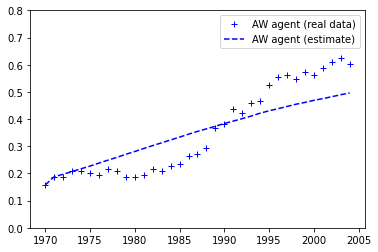

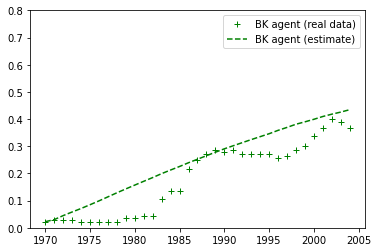

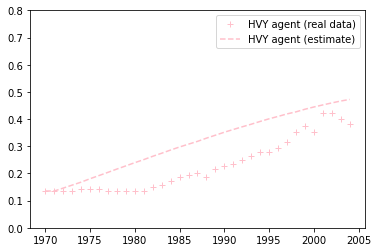

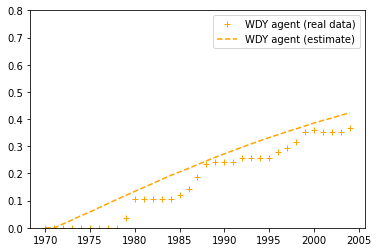

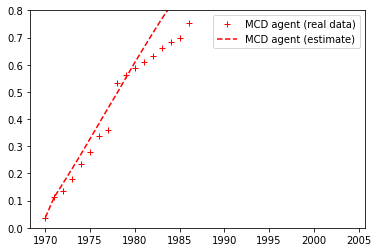

In [24]:
import matplotlib.pyplot as plt
year = np.arange(35,dtype=int)+1970

# plt.plot(year,Ni_mcd[tertile==mk].reshape([-1,35])[0],'b+')

# plt.plot(year,np.average(ostate1.T[0*Nsub*NX:(0+1)*Nsub*NX],axis=0),'g+')

# plt.plot(year,Ni_other[tertile_other==mk].reshape([-1,35])[0],'bo')

# plt.plot(year,np.average(ostate2.T[0*Nsub*NX:(0+1)*Nsub*NX],axis=0),'go')

#for i in range(MTsub):
plt.plot(year,np.mean(Ni_aw[tertile==mk].reshape([-1,35]),axis=0),'b+',label='AW agent (real data)')
plt.plot(year,np.mean(ostate2,axis=1),'b--',label='AW agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_bk[tertile==mk].reshape([-1,35]),axis=0),'g+',label='BK agent (real data)')
plt.plot(year,np.mean(ostate3,axis=1),'g--',label='BK agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_hvy[tertile==mk].reshape([-1,35]),axis=0),'+',color='pink',label='HVY agent (real data)')
plt.plot(year,np.mean(ostate4,axis=1),'--',color='pink',label='HVY agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_wdy[tertile==mk].reshape([-1,35]),axis=0),'+',color = 'orange',label='WDY agent (real data)')
plt.plot(year,np.mean(ostate5,axis=1),'--',color='orange',label='WDY agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_mcd[tertile==mk].reshape([-1,35]),axis=0),'r+',label='MCD agent (real data)')
plt.plot(year,np.mean(ostate1,axis=1),'r--',label='MCD agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()

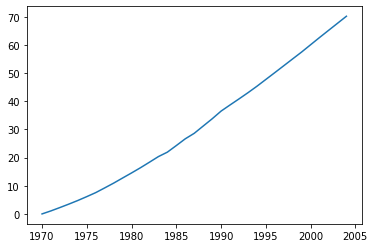

In [25]:
from sklearn.metrics import mean_squared_error

# a1_true = np.kron(ai_mcd[tertile==mk].reshape([-1,35]).T,np.ones(Nsub*NX))
# a2_true = np.kron(ai_other[tertile_other==mk].reshape([-1,35]).T,np.ones(Nsub*NX))
# ob1_true = np.kron(Ni_mcd[tertile==mk].reshape([-1,35]).T,np.ones(Nsub*NX))
# ob2_true = np.kron(Ni_other[tertile_other==mk].reshape([-1,35]).T,np.ones(Nsub*NX))
# z_true = np.kron(z_data,np.ones(Nsub*NX))

# mean_squared_error(a1_true.T,action1.T,multioutput='raw_values')
a1_true = ai_mcd[tertile==mk].reshape([-1,35])
a1_est = np.mean(action1.reshape([35,MTsub,NX*Nsub]),axis=2).T
a2_true = ai_aw[tertile==mk].reshape([-1,35])
a2_est = np.mean(action2.reshape([35,MTsub,NX*Nsub]),axis=2).T
a3_true = ai_bk[tertile==mk].reshape([-1,35])
a3_est = np.mean(action3.reshape([35,MTsub,NX*Nsub]),axis=2).T
a4_true = ai_hvy[tertile==mk].reshape([-1,35])
a4_est = np.mean(action4.reshape([35,MTsub,NX*Nsub]),axis=2).T
a5_true = ai_wdy[tertile==mk].reshape([-1,35])
a5_est = np.mean(action5.reshape([35,MTsub,NX*Nsub]),axis=2).T

ob1_true = Ni_mcd[tertile==mk].reshape([-1,35])
ob1_est = np.mean(ostate1.reshape([35,MTsub,NX*Nsub]),axis=2).T
ob2_true = Ni_aw[tertile==mk].reshape([-1,35])
ob2_est = np.mean(ostate2.reshape([35,MTsub,NX*Nsub]),axis=2).T
ob3_true = Ni_bk[tertile==mk].reshape([-1,35])
ob3_est = np.mean(ostate3.reshape([35,MTsub,NX*Nsub]),axis=2).T
ob4_true = Ni_hvy[tertile==mk].reshape([-1,35])
ob4_est = np.mean(ostate4.reshape([35,MTsub,NX*Nsub]),axis=2).T
ob5_true = Ni_wdy[tertile==mk].reshape([-1,35])
ob5_est = np.mean(ostate5.reshape([35,MTsub,NX*Nsub]),axis=2).T
z_true = z_data.T
z_est = np.mean(zstate.reshape([35,MTsub,NX*Nsub]),axis=2).T
#print(a1_est,a1_true,z_data.shape)

res = np.zeros(35)
res += mean_squared_error(a1_true,a1_est,multioutput='raw_values')
res += mean_squared_error(a2_true,a2_est,multioutput='raw_values')
res += mean_squared_error(a3_true,a3_est,multioutput='raw_values')
res += mean_squared_error(a4_true,a4_est,multioutput='raw_values')
res += mean_squared_error(a5_true,a5_est,multioutput='raw_values')

res += mean_squared_error(ob1_true,ob1_est,multioutput='raw_values')
res += mean_squared_error(ob2_true,ob2_est,multioutput='raw_values')
res += mean_squared_error(ob3_true,ob3_est,multioutput='raw_values')
res += mean_squared_error(ob4_true,ob4_est,multioutput='raw_values')
res += mean_squared_error(ob5_true,ob5_est,multioutput='raw_values')
res += mean_squared_error(z_true,z_est,multioutput='raw_values')


plt_res = []
for i in range(35):
  plt_res.append(np.sum(res[0:i+1]))
plt.plot(year,plt_res,'-')
plt.show()
# plt_res,res
#np.kron(np.arange(4),np.ones(3)).reshape([4,3])

#Complete

##1. Global transtion F_Ni, F_dz1,F_dz2,F_dz3

In [26]:
I = 2 #MCD and Other homogenous
J = 3 #Action: 0,1,2
NS = 4**(numstates)
NX = 2
#NZ = obser

#% F_Ni: Own # of shops changes deterministically, as follows
# F_Ni = np.zeros([I,J,NX,NZ,NS,NS])#;
# #for i in range(NX): 
# F_Ni[0,0] = np.kron(np.array([[1]*4+[0]*4 + [0] *4+[0]*4]*4 +\
#                           [[1]*4+[0]*4 + [0] *4+[0]*4]*4 + \
#                           [[0]*4+[1]*4 + [0] *4+[0]*4]*4 + \
#                           [[0]*4+[0]*4 + [1] *4+[0]*4]*4 ),np.ones([NX,NZ,1,1]))
# F_Ni[0,1] =np.kron(np.array([[1]*4+[0]*4 + [0] *4+[0]*4]*4 +\
#                           [[0]*4+[1]*4 + [0] *4+[0]*4]*4 + \
#                           [[0]*4+[0]*4 + [1] *4+[0]*4]*4 + \
#                           [[0]*4+[0]*4 + [0] *4+[1]*4]*4 ),np.ones([NX,NZ,1,1]))
# F_Ni[0,2] = np.kron(np.array([[0]*4+[1]*4 + [0] *4+[0]*4]*4 +\
#                           [[0]*4+[0]*4 + [1] *4+[0]*4]*4 + \
#                           [[0]*4+[0]*4 + [0] *4+[1]*4]*4 + \
#                           [[0]*4+[0]*4 + [0] *4+[1]*4]*4 ),np.ones([NX,NZ,1,1]))
# F_Ni[1] = F_Ni[0]
F_Ni = np.zeros([I,J,NX,NS,NS])#;
#for i in range(NX): 
F_Ni[0,0] = np.kron(np.array([[1]*4+[0]*4 + [0] *4+[0]*4]*4 +\
                          [[1]*4+[0]*4 + [0] *4+[0]*4]*4 + \
                          [[0]*4+[1]*4 + [0] *4+[0]*4]*4 + \
                          [[0]*4+[0]*4 + [1] *4+[0]*4]*4 ),np.ones([NX,1,1]))
F_Ni[0,1] =np.kron(np.array([[1]*4+[0]*4 + [0] *4+[0]*4]*4 +\
                          [[0]*4+[1]*4 + [0] *4+[0]*4]*4 + \
                          [[0]*4+[0]*4 + [1] *4+[0]*4]*4 + \
                          [[0]*4+[0]*4 + [0] *4+[1]*4]*4 ),np.ones([NX,1,1]))
F_Ni[0,2] = np.kron(np.array([[0]*4+[1]*4 + [0] *4+[0]*4]*4 +\
                          [[0]*4+[0]*4 + [1] *4+[0]*4]*4 + \
                          [[0]*4+[0]*4 + [0] *4+[1]*4]*4 + \
                          [[0]*4+[0]*4 + [0] *4+[1]*4]*4 ),np.ones([NX,1,1]))
F_Ni[1] = F_Ni[0]

##2. Dynamix and SigmaLambda

In [27]:
import itertools
dim_hstate = 2
dim_observe = obser
def Dynamic(theta23):
  trans_val = theta23[0:2]
  obser_val = theta23[2:]

  trans = np.zeros([dim_hstate,dim_hstate]) #s_t^h,s_{t+1}^h
  trans[:,0] = trans_val
  trans[:,1] = 1-trans[:,0]
  return trans
# print(Dynamic(np.array([0.95, 0.05])))#, 0.125])))#,0.125]+[0.1])))#,0.1,0.1])))  


## 3. Generate P(nj|policy)

In [28]:
F_fix = F_Ni
# % Calculate F from P (& global transition matrices F_Ni, F_dz1, F_dz2) 
import time
def updateF(P):
  #% For a given combination of (Ni, dz1, dz2, mtype), make the state indexes (x, x0, x1, x2, x3)
  #% Beliefs: mapping from today's state (Ni,Nj,dz1,dz2) to tomorrow's Nj = {0,1,2,3}
  fnj_mcd = np.zeros([NX,NS,4])#;      % McDonald's belief
  fnj_other = np.zeros([NX,NS,4])#;    % Other 4 chains beliefs

  nj = 0#;         % If today's # of rivals = 0
  x =  (4)*Ni + (1)*nj #+ (4**2)*dz1 + 4*dz2+dz3#;  % index of today's own state
  x0 = (4)*0 + (1)*Ni #+ (4**2)*dz1 + 4*dz2+dz3#;  % index of today's state for rivals with 0 shops

  fnj_mcd[:,x,0] = P[1,1][:,x0]**4#;                               % Prob(Nj'= 0) from McD's perspective
  fnj_mcd[:,x,1] = 4 * P[1,2][:,x0] * (P[1,1][:,x0]**3)#;       % Prob(Nj'= 1) from McD's perspective
  fnj_mcd[:,x,2] = 6 * (P[1,2][:,x0]**2) * (P[1,1][:,x0]**2)#;   % Prob(Nj'= 2) from McD's perspective
  fnj_mcd[:,x,3] = 4 * (P[1,2][:,x0]**3) * P[1,1][:,x0]#;       % Prob(Nj'= 3) from McD's perspective
  
  fnj_other[:,x,0] = P[0,1][:,x0] * (P[1,1][:,x0]**3)#;         % Prob(Nj'= 0) etc. from Others' perspectives
  fnj_other[:,x,1] = P[0,2][:,x0] * (P[1,1][:,x0]**3) + P[0,1][:,x0] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)#;  
  fnj_other[:,x,2] = P[0,2][:,x0] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2) + P[0,1][:,x0] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0]
  fnj_other[:,x,3] = P[0,2][:,x0] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0] + P[0,1][:,x0] * (P[1,2][:,x0]**3)

  
  nj = 1#;         % If today's # of rivals = 1                               
  x =  (4)*Ni + (1)*nj #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4)*0 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 =  (4)*1 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  
  fnj_mcd[:,x,0] = P[1,0][:,x1] * (P[1,1][:,x0]**3)#;
  fnj_mcd[:,x,1] = P[1,1][:,x1] * (P[1,1][:,x0]**3)#;
  fnj_mcd[:,x,2] = P[1,2][:,x1] * (P[1,1][:,x0]**3) + P[1,1][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)#;
  fnj_mcd[:,x,3] = P[1,2][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2) + P[1,1][:,x1] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0]
  
  fnj_other[:,x,0] = .5 * (P[0,0][:,x1] * P[1,1][:,x0]**3) + .5 * (P[0,1][:,x0] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,1] = .5 * (P[0,1][:,x1] * P[1,1][:,x0]**3) + .5 * (P[0,1][:,x0] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .5 * (P[0,2][:,x1] * (P[1,1][:,x0]**3) + P[0,1][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2))+\
                              .5 * (P[0,2][:,x0] * P[1,1][:,x1] * (P[1,1][:,x0]**2) +\
                        P[0,1][:,x0] * (P[1,2][:,x1] * (P[1,1][:,x0]**2) + P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]))
  fnj_other[:,x,3] = .5 * (P[0,2][:,x1] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)\
                        + P[0,1][:,x1] * 3 * (P[1,2][:,x0]**2) * P[1,1][:,x0])\
                        + .5 * (P[0,2][:,x0] * P[1,2][:,x1] * (P[1,1][:,x0]**2)\
                      + P[0,2][:,x0] * P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]\
                      + P[0,1][:,x0] * P[1,2][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0]\
                      + P[0,1][:,x0] * P[1,1][:,x1] * (P[1,2][:,x0]**2))

  nj = 2#;         % If today's # of rivals = 2
  x = (4)*Ni + (1)*nj #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4)*0 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 =  (4)*1 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  x2 = (4)*2 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 2 shops
  
  fnj_mcd[:,x,0] = (P[1,0][:,x1]**2) * (P[1,1][:,x0]**2)
  fnj_mcd[:,x,1] = (1/3) * (P[1,0][:,x2] * (P[1,1][:,x0]**3)) + (2/3) * (P[1,0][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,2] = (1/3) * (P[1,1][:,x2] * (P[1,1][:,x0]**3)) + (2/3) * ((P[1,1][:,x1]**2) * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,3] = (1/3) * (P[1,2][:,x2] * (P[1,1][:,x0]**3)  + (P[1,1][:,x2] * 3 * P[1,2][:,x0] * (P[1,1][:,x0]**2)))
  
  fnj_other[:,x,0] = .5 * 0 + .5 * (P[0,0][:,x1] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,1] = .5 * (P[0,0][:,x2] * (P[1,1][:,x0]**3))\
      + .5 * (P[0,0][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .5 * (P[0,1][:,x2] * (P[1,1][:,x0]**3))\
      + .5 * (P[0,1][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2))
  fnj_other[:,x,3] = .5 * (P[0,2][:,x2] * (P[1,1][:,x0]**3)\
      + P[0,1][:,x2] * 3 * P[1,2][:,x0] * P[1,1][:,x0])\
      + .5 * (P[0,2][:,x1] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,2][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,1][:,x1] * 2 * P[1,2][:,x0] * P[1,1][:,x0])
  
  nj = 3#;         % If today's # of rivals = 3
  x = (4)*Ni + (1)*nj #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's own state
  x0 = (4)*0 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 0 shops
  x1 =  (4)*1 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  x2 =  (4)*2 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 1 shops
  x3 = (4)*3 + (1)*Ni #+ (4**2)*dz1 +4*dz2+dz3#;  % index of today's state for rivals with 3 shops
  
  fnj_mcd[:,x,0] = (2/3) * (P[1,0][:,x1]**3) * P[1,1][:,x0]
  fnj_mcd[:,x,1] = (2/3) * (P[1,0][:,x1]**2) * P[1,1][:,x1] + (1/3) * P[1,0][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2)
  fnj_mcd[:,x,2] = (2/3) * P[1,0][:,x1] * (P[1,1][:,x1]**2) + (1/3) * (P[1,0][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[1,1][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))
  fnj_mcd[:,x,3] = (2/3) * (P[1,1][:,x1]**3) * P[1,1][:,x0] + (1/3) * P[1,1][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)
  
  fnj_other[:,x,0] = .25 * (P[0,0][:,x1] * (P[1,0][:,x1]**2) * P[1,1][:,x0])
  fnj_other[:,x,1] = .25 * 0 + .25 * (P[0,0][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,0][:,x1] * 2 * P[1,0][:,x1] * P[1,1][:,x1] * P[1,1][:,x0]\
      + P[0,1][:,x1] * (P[1,0][:,x1]**2) * P[1,1][:,x0])\
      + .25 * (P[0,0][:,x1] * P[1,0][:,x2] * (P[1,1][:,x0]**2))
  fnj_other[:,x,2] = .25 * (P[0,0][:,x3] * (P[1,1][:,x0]**3))\
      + .25 * (P[0,0][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x2] * P[1,0][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,0][:,x1] * (P[1,1][:,x1]**2) * P[1,1][:,x0]\
      + P[0,1][:,x1] * 2 * P[1,0][:,x1] * P[1,1][:,x1] * P[1,1][:,x0])\
      + .25 * (P[0,0][:,x1] * P[1,1][:,x2] * (P[1,1][:,x0]**2)\
      + P[0,1][:,x1] * P[1,0][:,x2] * (P[1,1][:,x0]**2))
  fnj_other[:,x,3] = .25 * (P[0,1][:,x3] * (P[1,1][:,x0]**3))\
      + .25 * (P[0,1][:,x2] * P[1,1][:,x1] * (P[1,1][:,x0]**2))\
      + .25 * (P[0,1][:,x1] * (P[1,1][:,x1]**2) * P[1,1][:,x0])\
      + .25 * (P[0,1][:,x1] * P[1,1][:,x2] * (P[1,1][:,x0]**2))

  F_Nj = np.ones([I,J,NX,NS,NS])
  Denom_mcd = np.matmul(fnj_mcd,np.ones([NX,4,4]))#np.kron(np.reshape(np.sum(fnj_mcd,axis=2),[NX,-1,1]),np.ones([1,1,4]))#;         % Sum of each row
  fnj_mcd = fnj_mcd / Denom_mcd#;                 % Make sure each row sums up to 1
  fnj_mcd[np.isnan(fnj_mcd)] = 0#;                    % Replace NaN with 0
  F_Nj[0,0] = fnj_mcd[:,:,Nj]

  Denom_other = np.matmul(fnj_other,np.ones([NX,4,4]))#np.kron(np.reshape(np.sum(fnj_other,axis=2),[NX,-1,1]),np.ones([1,1,4]))#;             % Sum of each row
  fnj_other = fnj_other / Denom_other#;                   % Make sure each row sums up to 1
  fnj_other[np.isnan(fnj_other)] = 0#;                        % Replace NaN with 0
  F_Nj[1,0] = fnj_other[:,:,Nj]
  #F_Nj[2:5,j,:,:] = np.stack([F_Nj[1,j,:,:] for copy in range(3)],axis=0)#;    % Other 4 chains are symmetric

  for j in range(1,J):    
      F_Nj[:,j] = F_Nj[:,0]    
  return F_Nj*F_fix

# P_new = 1/J*np.ones([I,J,NX,NS])#softmax(np.arange(I*J*NS).reshape([I,J,NS]),axis=1)
# F_new = updateF(P_new.copy())
# #np.sum(F_new!=0)
# print(F_new.shape)

##4.Value Iteration

In [29]:
from scipy.special import logsumexp
from scipy.special import softmax

def updatePi(Q):
  P = np.zeros([I,J,NX,NS])#; player, action,NZ, states, Market Type
  P[0] = softmax(Q[0],axis=0)
  P[1] = softmax(Q[1],axis=0)
  P[np.isnan(P)] = 0#;
  return P

def updateQ(thetaS,Q,F,trans,Q_new,beta = 0.9):

  gamma = 0.5772
    
  #v_mcd = np.zeros([J,NX,obser,NS])
  #v_other = np.zeros([J,NX,obser,NS])

  v_mcd= Q[0] # (Agent), action, NZ_new,NS_new
  v_other = Q[1]
  #v_mcd = np.stack([iterpP*Q[0,j][iterf]+(1-iterpP)*Q[0,j][iterc] for j in range(J)],axis=0)
  #v_other = np.stack([iterpP*Q[1,j][iterf]+(1-iterpP)*Q[1,j][iterc] for j in range(J)],axis=0)
  v_mcd = gamma + logsumexp(v_mcd,axis=0) #(action), NZ_new,NS_new
  v_other = gamma + logsumexp(v_other,axis=0)
  v_mcd = trans.dot(v_mcd).reshape([1,NX,NS,1]) #NZ_old,NS_new
  v_other = trans.dot(v_other).reshape([1,NX,NS,1])
  v_mcd = np.kron(v_mcd,np.ones([J,1,1,1])) #a_old,NZ_old,NS_new,1
  v_other = np.kron(v_other,np.ones([J,1,1,1])) #a_old,NZ_old,NS_new,1

  v_temp_mcd = np.matmul(F[0],v_mcd)[:,:,:,0] # action_old,nz_old, ns_old (ns_new \times ns_new)
  v_temp_other = np.matmul(F[1],v_other)[:,:,:,0] 

  Q_new[0] = Q_new[0] + beta*(v_temp_mcd) 
  Q_new[1] = Q_new[1] + beta*(v_temp_other)
  return Q_new

# theta23 = np.array([0.95, 0.05])#, 0.1,0.9,0.1])#,0.1,0.1])
# trans = Dynamic(theta23)



import time

def ValueIteration(thetaS,trans,error = 5e-3,beta = 0.9):
  Pi0 = 1/3*np.ones([I,J,NX,NS])
  F0= updateF(Pi0)
  Q0 = np.zeros([I,J,NX,NS])
  Pi_old = Pi0
  F_old = F0
  Q_old = Q0

  #x_old = np.linspace(0,1,num=NX).reshape([-1,1])
  R_new = np.zeros([I,J,NX,NS])
  thetaS_mcd = np.reshape(np.array([thetaS[2],thetaS[3],thetaS[4]]),[-1,1])
  thetaS_other = np.reshape(np.array([thetaS[7],thetaS[8],thetaS[9]]),[-1,1])
  #Ni_temp = (Ni).reshape([1,-1])

  r_mcd_a2 = np.stack([Ni *Ni,Ni*Nj, -1* np.ones(NS)],axis=1).dot(thetaS_mcd)
  r_mcd_a1 = np.stack([Ni *Ni,Ni*Nj, 0* np.ones(NS)],axis=1).dot(thetaS_mcd)
  # print(r_mcd_a2.shape,r_mcd_a2.T[0].shape,Ni.shape)
  R_new[0,2,0] =   r_mcd_a2.T[0] + thetaS[0]*Ni
  R_new[0,2,1] = r_mcd_a2.T[0] + thetaS[1]*Ni

  R_new[0,1,0] =   r_mcd_a1.T[0] + thetaS[0]*Ni
  R_new[0,1,1] = r_mcd_a1.T[0] + thetaS[1]*Ni
  R_new[0,0] = R_new[0,1].copy()

  r_other_a2 = np.stack([Ni *Ni,Ni*Nj, -1* np.ones(NS)],axis=1).dot(thetaS_other)
  r_other_a1 = np.stack([Ni *Ni,Ni*Nj, 0* np.ones(NS)],axis=1).dot(thetaS_other)

  R_new[1,2,0] =  r_other_a2.T[0]+ thetaS[5]*Ni   
  R_new[1,2,1] =  r_other_a2.T[0]+ thetaS[6]*Ni   

  R_new[1,1,0] =  r_other_a1.T[0] + thetaS[5]*Ni
  R_new[1,1,1] =  r_other_a1.T[0] + thetaS[6]*Ni

  R_new[1,0] = R_new[1,1].copy()
  error1 = np.inf
  for iter in range(1000):
    # time_start = time.time()
    Q_new = updateQ(thetaS,Q_old,F_old,trans,Q_new = R_new.copy(),beta=beta) #I, J, NS
    Pi_new = updatePi(Q_new)#I,J,NS
    #time_start1 = time.time()
    #print(time_start1-time_start)
    F_new = updateF(Pi_new) # I, J, NS,NS
    #print(time.time()-time_start1)
    if iter>0:
      error1 = np.max(np.abs(Q_new-Q_old))/np.max(np.abs(Q_old))
    # error2 = np.max(np.abs(Pi_new-Pi_old))/np.max(np.abs(Pi_old))
    # error3 = np.max(np.abs(F_new-F_old))/np.max(np.abs(F_old))
    # print('iteration {} --> e1:{:.4f}({:.4f}), e2:{:.4f}({:.4f}), e3:{:.4f}({:.4f}), time:{}'.format(iter,error1,np.max(np.abs(Q_old)),error2,np.max(np.abs(Pi_old)),error3,np.max(np.abs(F_old)),time.time()-time_start))
    # #print('iteration {} --> e1:{},time:{}'.format(iter,error1,time.time()-time_start))

    if error1<error :#and error2<error and error3<error:
      #print('iteration {} --> e1:{},e2:{},e3:{}'.format(iter,error1,error2,error3))
      break
    Q_old = Q_new.copy()
    Pi_old = Pi_new.copy()
    F_old = F_new.copy()
  return Q_new, Pi_new,F_new

# thetaS = np.array([3.9488,2.4672,-2.5972,-0.4203,12.5872,
#                    1.3230,1.1637,-0.5400,-0.1731,7.6820])
# #thetaS = np.zeros(5*2)
# Q_new, Pi_new,F_new = ValueIteration(thetaS,trans)

##5. log-likelihood (Complete)

In [30]:
import pickle
#with open(file_name+'/transition.txt','rb') as fp:

with open('/content/drive/MyDrive/2022_SUMMER/Research_Burger/Picture/transition.txt','rb') as fp:
  haha = pickle.load(fp)
print(haha)
for i in [2012,2021]:
  for j in ['year','quater','month']:
    print(i,j,haha[i][j][0,0]/np.sum(haha[i][j][0]),haha[i][j][1,0]/np.sum(haha[i][j][1]))
    haha[i][j] = np.array([haha[i][j][0,0]/np.sum(haha[i][j][0]),haha[i][j][1,0]/np.sum(haha[i][j][1])])
haha

{2012: {'year': array([[ 5,  3],
       [ 3, 23]]), 'quater': array([[ 18,   4],
       [  4, 113]]), 'month': array([[ 49,   4],
       [  4, 362]])}, 2021: {'year': array([[ 4,  3],
       [ 3, 24]]), 'quater': array([[ 17,   3],
       [  3, 116]]), 'month': array([[ 47,   3],
       [  3, 366]])}}
2012 year 0.625 0.11538461538461539
2012 quater 0.8181818181818182 0.03418803418803419
2012 month 0.9245283018867925 0.01092896174863388
2021 year 0.5714285714285714 0.1111111111111111
2021 quater 0.85 0.025210084033613446
2021 month 0.94 0.008130081300813009


{2012: {'year': array([0.625     , 0.11538462]),
  'quater': array([0.81818182, 0.03418803]),
  'month': array([0.9245283 , 0.01092896])},
 2021: {'year': array([0.57142857, 0.11111111]),
  'quater': array([0.85      , 0.02521008]),
  'month': array([0.94      , 0.00813008])}}

In [31]:
tertile_other = np.hstack([tertile,tertile,tertile,tertile])

In [32]:
disc_gdp_other = disc_gdp#np.hstack([disc_gdp for i in range(4)])
disc_gdp_mcd = disc_gdp.copy()
z_data = disc_gdp[tertile==mk].reshape([-1,TimePeriod]).T
x_data = (1/obser)*np.ones(z_data.shape[1])*0+1

In [33]:
#theta23,trans_gdp

In [34]:
from scipy.optimize import minimize
lower_bound = 1e-4
# a1 = None#0.8993 # None#
# a2 = 0.008  #None#
def func1(theta23):
  # if a1!=None:
  #   theta23 = np.hstack([[a1,a2],theta23])
  # theta23[0],theta23[1] = 0.8993,0.008
  trans = Dynamic(theta23)
  #sigma_val[np.isnan(sigma_val)] = 0
  res = -np.sum(np.log(trans[z_data[0:-1],z_data[1:]]))

  print(theta23,res)
  return res #/(5*MT)

from scipy import optimize
init_x0 = trans_gdp[:,0]#np.array([0.8993,0.008])# ,0.53673132])#, 1-2*lower_bound, 2*lower_bound])#theta23
rranges = [(0+lower_bound,1-lower_bound),(0+lower_bound,1-lower_bound)]
print('start from:',init_x0)
cons=[{'type':'ineq', 'fun': lambda x: 1-x[2]-x[3]-x[4]},
      {'type':'ineq', 'fun': lambda x: 1-x[5]-x[6]-x[7]},
      {'type':'ineq', 'fun': lambda x: x[3]-x[6]}]
res1_comp = minimize(func1,init_x0,bounds = rranges)#,constraints=cons)#,options={'maxiter':1000},tol=1e-5)
print(res1_comp,res1_comp.fun)#*5*MT)
print(Dynamic(res1_comp.x))
# rranges = [(0.5+lower_bound,1-lower_bound),(0+lower_bound,0.5-lower_bound),
#            (0.5+lower_bound,1-lower_bound),(0.5+lower_bound,1-lower_bound)]
# resbrute = optimize.brute(func1, rranges, finish=None,Ns=10)
# print(resbrute,func1(resbrute))
trans_est = np.zeros([2,2])
trans_est[:,0] = res1_comp.x[0:2]
trans_est[:,1] = 1-trans_est[:,0]
#print(trans_est)
pi_distEst = trans_est.copy()
for i in range(200):
  pi_distEst = pi_distEst.dot(trans_est)
print('----->',pi_distEst[0])
# [[0.94       0.06      ]
#  [0.00813008 0.99186992]]
# -----> [0.11933235 0.88066765

start from: [0.83333333 0.1875    ]
[0.83333333 0.1875    ] 2105.568592722615
[0.83333334 0.1875    ] 2105.568592722616
[0.83333333 0.18750001] 2105.568592722616
[0.83324238 0.18740905] 2105.5687217779764
[0.83324239 0.18740905] 2105.5687217623076
[0.83324238 0.18740906] 2105.568721765268
[0.83333333 0.18749999] 2105.568592722616
[0.83333334 0.18749999] 2105.5685927226154
[0.83333333 0.1875    ] 2105.568592722616
[0.83333333 0.1875    ] 2105.568592722615
[0.83333334 0.1875    ] 2105.5685927226154
[0.83333333 0.18750001] 2105.5685927226154
      fun: 2105.568592722615
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.54747349e-05, 4.54747351e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 1
     njev: 4
   status: 0
  success: True
        x: array([0.83333333, 0.1875    ]) 2105.568592722615
[[0.83333333 0.16666667]
 [0.1875     0.8125    ]]
-----> [0.52941176 0.47058824]


In [35]:
z_data.T.reshape(-1)

array([1, 0, 0, ..., 1, 1, 1])

In [36]:

norm_thetaS = 1
trans = Dynamic(res1_comp.x)
z_data_old = z_data.T.reshape(-1)
def func(thetaS,trans=trans):
  _, Pi_new,_ = ValueIteration(thetaS*norm_thetaS,trans)
  #print(np.unique(a_mcd))
  res = -np.sum(np.log(  Pi_new[0,ai_mcd[tertile==mk],z_data_old,stateID_mcd[tertile==mk]]))
  res = res -np.sum(np.log(  Pi_new[1,ai_other[tertile_other==mk],np.hstack([z_data_old for i in range(4)]),stateID_other[tertile_other==mk]]))
  print(thetaS*norm_thetaS,res)
  return res/5/MT
from scipy.optimize import minimize

# thetaS = np.array([(3.9488+2.4672)/2,-2.5972,-2.5972,-0.4203,0.0931,0.1513,0.0730,12.5872,
#                    (1.3230+1.1637)/2,-0.5400,-0.5400,-0.1731,0.0596,0.0413,0.0116,7.6820])

#thetaS = np.zeros((7+1)*2)
# thetaS = 0*np.array([2.4672,3.9488,-2.5972,-0.4203,12.5872,
#                    1.1637,1.3230,-0.5400,-0.1731,7.6820])/norm_thetaS
thetaS = np.array([1.71975799,  2.08581435, -0.37481475, -0.02593636,  8.98705047,
        1.02327539,  1.25944922, -0.21653006,  0.01061199,  5.32707651])/norm_thetaS
print('start from:',thetaS*norm_thetaS )
res22_comp = minimize(func,thetaS,options={'maxiter':4000},tol=1e-4)
print(res22_comp)
print(res22_comp.x*norm_thetaS,res22_comp.fun*5*MT) # 28min

start from: [ 1.71975799  2.08581435 -0.37481475 -0.02593636  8.98705047  1.02327539
  1.25944922 -0.21653006  0.01061199  5.32707651]
[ 1.71975799  2.08581435 -0.37481475 -0.02593636  8.98705047  1.02327539
  1.25944922 -0.21653006  0.01061199  5.32707651] 14734.17756478084
[ 1.719758    2.08581435 -0.37481475 -0.02593636  8.98705047  1.02327539
  1.25944922 -0.21653006  0.01061199  5.32707651] 14734.17756354104
[ 1.71975799  2.08581436 -0.37481475 -0.02593636  8.98705047  1.02327539
  1.25944922 -0.21653006  0.01061199  5.32707651] 14734.177563686091
[ 1.71975799  2.08581435 -0.37481474 -0.02593636  8.98705047  1.02327539
  1.25944922 -0.21653006  0.01061199  5.32707651] 14734.177560708633
[ 1.71975799  2.08581435 -0.37481475 -0.02593635  8.98705047  1.02327539
  1.25944922 -0.21653006  0.01061199  5.32707651] 14734.177561140425
[ 1.71975799  2.08581435 -0.37481475 -0.02593636  8.98705048  1.02327539
  1.25944922 -0.21653006  0.01061199  5.32707651] 14734.177565073305
[ 1.71975799  2

In [37]:
import numpy as np

haha = res22_comp.x*norm_thetaS
print('{:.4f}&{:.4f}'.format(haha[0],haha[5]))
print('{:.4f}&{:.4f}'.format(haha[1],haha[6]))
print('{:.4f}&{:.4f}'.format(haha[2],haha[7]))
print('{:.4f}&{:.4f}'.format(haha[3],haha[8]))
print('{:.4f}&{:.4f}'.format(haha[4],haha[9]))



1.7492&1.3579
2.1416&1.6592
-0.3860&-0.3953
-0.0370&-0.0045
8.9701&7.1353


##6.MSE

In [38]:
from tqdm import tqdm
Nsub = 5
MTsub = int(len(ai_mcd[tertile==mk])/35)

dim_a = 3
dy_aiso = np.zeros([dim_a,4,4])
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_aiso[ai,ni_old,ni_new] = 1
dy_aiso[0,0,0] = 1
dy_aiso[2,3,3] = 1

def DataGeneration(theta1 = res22_comp.x,theta23=res1_comp.x,T=35,N=int(Nsub*NX*MTsub),Nsub = Nsub,num=NX):



  trans = Dynamic(theta23)
  _, Pi_new,_ = ValueIteration(theta1,trans)
  pi1 = Pi_new[0]#Action,belief,state
  pi2 = Pi_new[1]

  ostate1 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n1)
  ostate2 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate3 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate4 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)
  ostate5 = np.zeros([T,N],dtype = int)  #observalbe state s^o =(n2)

  zstate = np.zeros([T,N],dtype = int)   #observation state z
  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action
  action3 = np.zeros([T,N],dtype = int)   #agent2's action
  action4 = np.zeros([T,N],dtype = int)   #agent2's action
  action5 = np.zeros([T,N],dtype = int)   #agent2's action

  zstate[0,:] = np.int_(np.kron(z_data[0],
                                np.ones(Nsub*num,dtype = int)))#np.int_(obser[hstate[0],0]<=zstate_mat) # random generate income
  ostate1[0,:] = np.int_(np.kron(Ni_mcd[tertile==mk].reshape([-1,35]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)                              
  ostate2[0,:] = np.int_(np.kron(Ni_aw[tertile==mk].reshape([-1,35]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate3[0,:] = np.int_(np.kron(Ni_bk[tertile==mk].reshape([-1,35]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate4[0,:] = np.int_(np.kron(Ni_hvy[tertile==mk].reshape([-1,35]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  ostate5[0,:] = np.int_(np.kron(Ni_wdy[tertile==mk].reshape([-1,35]).T[0],
                             np.ones(Nsub*num)))#0#np.random.randint(0,dim_so,size=N)  
  action1[0,:] = np.int_(np.kron(ai_mcd[tertile==mk].reshape([-1,35]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action2[0,:] = np.int_(np.kron(ai_aw[tertile==mk].reshape([-1,35]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action3[0,:] = np.int_(np.kron(ai_bk[tertile==mk].reshape([-1,35]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  action4[0,:] = np.int_(np.kron(ai_hvy[tertile==mk].reshape([-1,35]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)  
  action5[0,:] = np.int_(np.kron(ai_wdy[tertile==mk].reshape([-1,35]).T[0],
                                 np.ones(Nsub*num)))#np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)

  for t in tqdm(range(T-1)):
    
    # generate new hidden state and observation state
    zstate_mat = np.random.random(size=N)
    zstate[t+1,:] = np.int_(trans[zstate[t,:],0]<=zstate_mat) # random generate income

    ostate1[t+1,:] = np.int_(np.where(dy_aiso[action1[t],ostate1[t],:]==1)[1])#n1
    ostate2[t+1,:] = np.int_(np.where(dy_aiso[action2[t],ostate2[t],:]==1)[1])#n2
    ostate3[t+1,:] = np.int_(np.where(dy_aiso[action3[t],ostate3[t],:]==1)[1])#n2
    ostate4[t+1,:] = np.int_(np.where(dy_aiso[action4[t],ostate4[t],:]==1)[1])#n2
    ostate5[t+1,:] = np.int_(np.where(dy_aiso[action5[t],ostate5[t],:]==1)[1])#n2

    # generate new action for both agents
    osj_aw = ostate3[t+1,:] + ostate4[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_bk = ostate2[t+1,:] + ostate4[t+1,:] + ostate1[t+1,:] + ostate5[t+1,:]
    osj_hvy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate1[t+1,:] + ostate5[t+1,:]
    osj_mcd = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate5[t+1,:]
    osj_wdy = ostate2[t+1,:] + ostate3[t+1,:]  + ostate4[t+1,:] + ostate1[t+1,:]
    osj_aw = (osj_aw <= 3)*osj_aw + (osj_aw > 3)*3     
    osj_bk = (osj_bk <= 3)*osj_bk + (osj_bk > 3)*3
    osj_hvy = (osj_hvy <= 3)*osj_hvy + (osj_hvy > 3)*3
    osj_mcd = (osj_mcd <= 3)*osj_mcd + (osj_mcd > 3)*3
    osj_wdy = (osj_wdy <= 3)*osj_wdy + (osj_wdy > 3)*3

    os1 = np.int_(ostate1[t+1,:]*4 +osj_mcd )
    os2 = np.int_(ostate2[t+1,:]*4 + osj_aw)
    os3 = np.int_(ostate3[t+1,:]*4 +osj_bk )
    os4 = np.int_(ostate4[t+1,:]*4 + osj_hvy)
    os5 = np.int_(ostate5[t+1,:]*4 +osj_wdy )

    action_mat1 = np.random.random(size=N)
    p11 = pi1[0,zstate[t+1,:],os1]
    p12 = pi1[1,zstate[t+1,:],os1] 
    action1[t+1,:] = np.int_(p11<=action_mat1) + np.int_(p12 + p11 <= action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p21 = pi2[0,zstate[t+1,:],os2] 
    p22 = pi2[1,zstate[t+1,:],os2] 
    action2[t+1,:] = np.int_(p21<=action_mat2) + np.int_(p22 + p21 <= action_mat2)
    
    action_mat3 = np.random.random(size=N)
    p31 = pi2[0,zstate[t+1,:],os3] 
    p32 = pi2[1,zstate[t+1,:],os3] 
    action3[t+1,:] = np.int_(p31<=action_mat3) + np.int_(p32 + p31 <= action_mat3)

    action_mat4 = np.random.random(size=N)
    p41 = pi2[0,zstate[t+1,:],os4] 
    p42 = pi2[1,zstate[t+1,:],os4] 
    action4[t+1,:] = np.int_(p41<=action_mat4) + np.int_(p42 + p41 <= action_mat4)

    action_mat5 = np.random.random(size=N)
    p51 = pi2[0,zstate[t+1,:],os5] 
    p52 = pi2[1,zstate[t+1,:],os5] 
    action5[t+1,:] = np.int_(p51<=action_mat5) + np.int_(p52 + p51 <= action_mat5)
  return ostate1,ostate2,ostate3,ostate4,ostate5, zstate,action1,action2,action3,action4,action5


ostate1_comp,ostate2_comp,ostate3_comp,ostate4_comp,ostate5_comp, zstate_comp,action1_comp,action2_comp,action3_comp,action4_comp,action5_comp= DataGeneration()

100%|██████████| 34/34 [00:00<00:00, 1518.98it/s]


In [39]:
# print(np.array([np.sum(action1==i) for i in range(dim_a)])/TimePeriod/SamplePath)
# print(np.array([np.sum(action2==i) for i in range(dim_a)])/TimePeriod/SamplePath)
# print(np.array([np.sum(hstate==i) for i in range(2)])/(TimePeriod+1)/SamplePath)
# print(np.array([np.sum(ostate1==i) for i in range(4)])/(TimePeriod+1)/SamplePath)
# print(np.array([np.sum(ostate2==i) for i in range(4)])/(TimePeriod+1)/SamplePath)
# print(np.array([np.sum(zstate==i) for i in range(2)])/(TimePeriod+1)/SamplePath)

# [0.38001042 0.49154167 0.12844792]
# [0.09610417 0.75103125 0.15286458]
# [0.5023873 0.4976127]
# [0.00634221 0.29677254 0.29152664 0.00592213 0.16026639 0.20493852
#  0.00241803 0.01419057 0.01762295]
# [0.50172131 0.49827869]

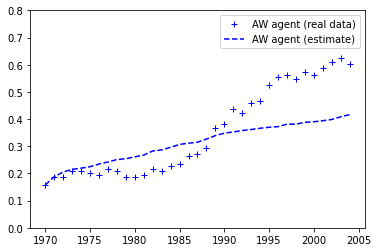

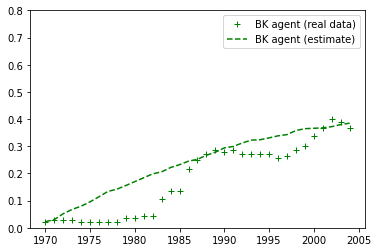

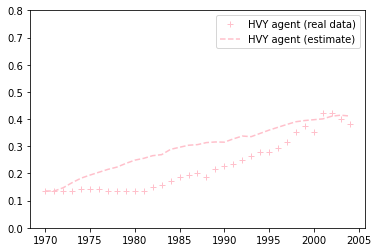

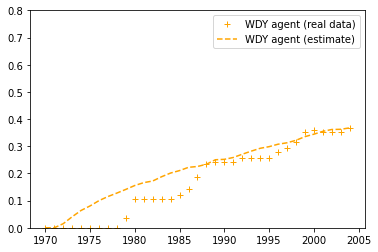

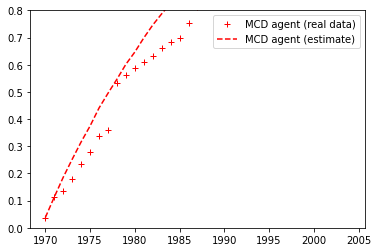

In [40]:
import matplotlib.pyplot as plt
year = np.arange(35,dtype=int)+1970

# plt.plot(year,Ni_mcd[tertile==mk].reshape([-1,35])[0],'b+')

# plt.plot(year,np.average(ostate1.T[0*Nsub*NX:(0+1)*Nsub*NX],axis=0),'g+')

# plt.plot(year,Ni_other[tertile_other==mk].reshape([-1,35])[0],'bo')

# plt.plot(year,np.average(ostate2.T[0*Nsub*NX:(0+1)*Nsub*NX],axis=0),'go')

#for i in range(MTsub):
plt.plot(year,np.mean(Ni_aw[tertile==mk].reshape([-1,35]),axis=0),'b+',label='AW agent (real data)')
plt.plot(year,np.mean(ostate2_comp,axis=1),'b--',label='AW agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_bk[tertile==mk].reshape([-1,35]),axis=0),'g+',label='BK agent (real data)')
plt.plot(year,np.mean(ostate3_comp,axis=1),'g--',label='BK agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_hvy[tertile==mk].reshape([-1,35]),axis=0),'+',color='pink',label='HVY agent (real data)')
plt.plot(year,np.mean(ostate4_comp,axis=1),'--',color='pink',label='HVY agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_wdy[tertile==mk].reshape([-1,35]),axis=0),'+',color = 'orange',label='WDY agent (real data)')
plt.plot(year,np.mean(ostate5_comp,axis=1),'--',color='orange',label='WDY agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()
plt.plot(year,np.mean(Ni_mcd[tertile==mk].reshape([-1,35]),axis=0),'r+',label='MCD agent (real data)')
plt.plot(year,np.mean(ostate1_comp,axis=1),'r--',label='MCD agent (estimate)')
plt.ylim(0,0.8)
plt.legend()
plt.show()

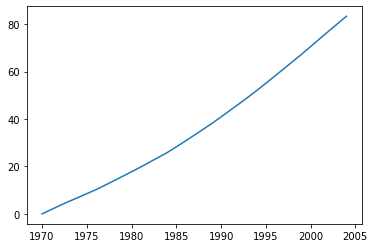

In [41]:
from sklearn.metrics import mean_squared_error

# a1_true = np.kron(ai_mcd[tertile==mk].reshape([-1,35]).T,np.ones(Nsub*NX))
# a2_true = np.kron(ai_other[tertile_other==mk].reshape([-1,35]).T,np.ones(Nsub*NX))
# ob1_true = np.kron(Ni_mcd[tertile==mk].reshape([-1,35]).T,np.ones(Nsub*NX))
# ob2_true = np.kron(Ni_other[tertile_other==mk].reshape([-1,35]).T,np.ones(Nsub*NX))
# z_true = np.kron(z_data,np.ones(Nsub*NX))

# mean_squared_error(a1_true.T,action1.T,multioutput='raw_values')
a1_true = ai_mcd[tertile==mk].reshape([-1,35])
a1_est_comp = np.mean(action1_comp.reshape([35,MTsub,NX*Nsub]),axis=2).T
a2_true = ai_aw[tertile==mk].reshape([-1,35])
a2_est_comp = np.mean(action2_comp.reshape([35,MTsub,NX*Nsub]),axis=2).T
a3_true = ai_bk[tertile==mk].reshape([-1,35])
a3_est_comp = np.mean(action3_comp.reshape([35,MTsub,NX*Nsub]),axis=2).T
a4_true = ai_hvy[tertile==mk].reshape([-1,35])
a4_est_comp = np.mean(action4_comp.reshape([35,MTsub,NX*Nsub]),axis=2).T
a5_true = ai_wdy[tertile==mk].reshape([-1,35])
a5_est_comp = np.mean(action5_comp.reshape([35,MTsub,NX*Nsub]),axis=2).T

ob1_true = Ni_mcd[tertile==mk].reshape([-1,35])
ob1_est_comp = np.mean(ostate1_comp.reshape([35,MTsub,NX*Nsub]),axis=2).T
ob2_true = Ni_aw[tertile==mk].reshape([-1,35])
ob2_est_comp = np.mean(ostate2_comp.reshape([35,MTsub,NX*Nsub]),axis=2).T
ob3_true = Ni_bk[tertile==mk].reshape([-1,35])
ob3_est_comp = np.mean(ostate3_comp.reshape([35,MTsub,NX*Nsub]),axis=2).T
ob4_true = Ni_hvy[tertile==mk].reshape([-1,35])
ob4_est_comp = np.mean(ostate4_comp.reshape([35,MTsub,NX*Nsub]),axis=2).T
ob5_true = Ni_wdy[tertile==mk].reshape([-1,35])
ob5_est_comp = np.mean(ostate5_comp.reshape([35,MTsub,NX*Nsub]),axis=2).T
z_true = z_data.T
z_est_comp = np.mean(zstate_comp.reshape([35,MTsub,NX*Nsub]),axis=2).T
#print(a1_est,a1_true,z_data.shape)

res_comp = np.zeros(35)
res_comp += mean_squared_error(a1_true,a1_est_comp,multioutput='raw_values')
res_comp += mean_squared_error(a2_true,a2_est_comp,multioutput='raw_values')
res_comp += mean_squared_error(a3_true,a3_est_comp,multioutput='raw_values')
res_comp += mean_squared_error(a4_true,a4_est_comp,multioutput='raw_values')
res_comp += mean_squared_error(a5_true,a5_est_comp,multioutput='raw_values')

res_comp += mean_squared_error(ob1_true,ob1_est_comp,multioutput='raw_values')
res_comp += mean_squared_error(ob2_true,ob2_est_comp,multioutput='raw_values')
res_comp += mean_squared_error(ob3_true,ob3_est_comp,multioutput='raw_values')
res_comp += mean_squared_error(ob4_true,ob4_est_comp,multioutput='raw_values')
res_comp += mean_squared_error(ob5_true,ob5_est_comp,multioutput='raw_values')
res_comp += mean_squared_error(z_true,z_est_comp,multioutput='raw_values')


plt_res_comp = []
for i in range(35):
  plt_res_comp.append(np.sum(res_comp[0:i+1]))
plt.plot(year,plt_res_comp,'-')
# plt_res,res
#np.kron(np.arange(4),np.ones(3)).reshape([4,3])

# Comparison

In [56]:
print('       Partial  &   Complete  & Improvment(%)')
print('l1:  {:.4f} &  {:.4f} & {:.4f}%'.format(-res1.fun,-res1_comp.fun,-(res1.fun-res1_comp.fun)/res1_comp.fun*100))
print('l2: {:.4f} & {:.4f} & {:.4f}%'.format(-res22.fun*5*MT,-res22_comp.fun*5*MT,-(res22.fun-res22_comp.fun)/res22_comp.fun*100))
l_partial = (res1.fun+res22.fun*5*MT)
l_complete = (res1_comp.fun+res22_comp.fun*5*MT)
print('l : {:.4f} & {:.4f} & {:.4f}%'.format(-l_partial,-l_complete,(l_complete-l_partial)/l_complete*100))

       Partial  &   Complete  & Improvment(%)
l1:  -1589.8726 &  -2105.5686 & 24.4920%
l2: -14050.9897 & -14052.4663 & 0.0105%
l : -15640.8624 & -16158.0349 & 3.2007%


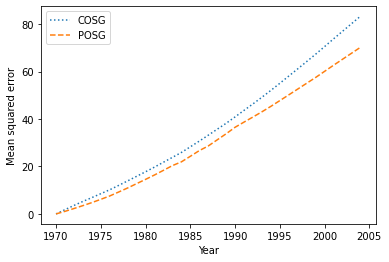

In [57]:
plt.plot(year,plt_res_comp,':',label='COSG')
plt.plot(year,plt_res,'--',label="POSG")
plt.ylabel('Mean squared error')
plt.xlabel('Year')
plt.legend()
plt.show()

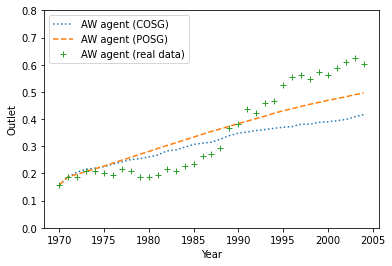

In [58]:
plt.plot(year,np.mean(ostate2_comp,axis=1),':',label='AW agent (COSG)')
plt.plot(year,np.mean(ostate2,axis=1),'--',label='AW agent (POSG)')
plt.plot(year,np.mean(Ni_aw[tertile==mk].reshape([-1,35]),axis=0),'+',label='AW agent (real data)')
plt.ylabel('Outlet')
plt.xlabel('Year')
plt.ylim(0,0.8)
plt.legend()
plt.show()

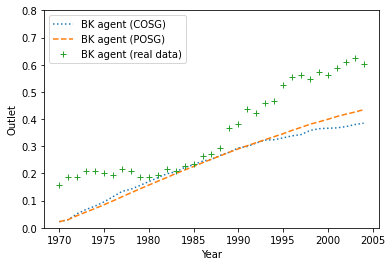

In [59]:
plt.plot(year,np.mean(ostate3_comp,axis=1),':',label='BK agent (COSG)')
plt.plot(year,np.mean(ostate3,axis=1),'--',label='BK agent (POSG)')
plt.plot(year,np.mean(Ni_aw[tertile==mk].reshape([-1,35]),axis=0),'+',label='BK agent (real data)')
plt.ylabel('Outlet')
plt.xlabel('Year')
plt.ylim(0,0.8)
plt.legend()
plt.show()

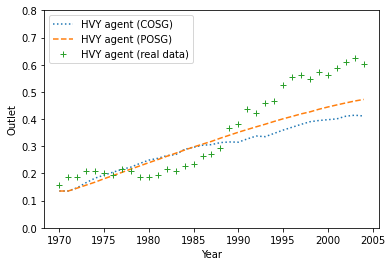

In [60]:
plt.plot(year,np.mean(ostate4_comp,axis=1),':',label='HVY agent (COSG)')
plt.plot(year,np.mean(ostate4,axis=1),'--',label='HVY agent (POSG)')
plt.plot(year,np.mean(Ni_aw[tertile==mk].reshape([-1,35]),axis=0),'+',label='HVY agent (real data)')
plt.ylabel('Outlet')
plt.xlabel('Year')
plt.ylim(0,0.8)
plt.legend()
plt.show()

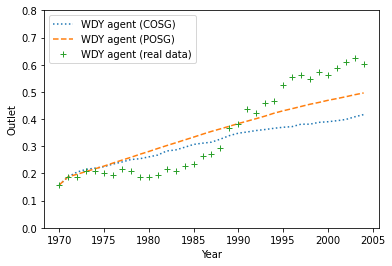

In [61]:
plt.plot(year,np.mean(ostate2_comp,axis=1),':',label='WDY agent (COSG)')
plt.plot(year,np.mean(ostate2,axis=1),'--',label='WDY agent (POSG)')
plt.plot(year,np.mean(Ni_aw[tertile==mk].reshape([-1,35]),axis=0),'+',label='WDY agent (real data)')
plt.ylabel('Outlet')
plt.xlabel('Year')
plt.ylim(0,0.8)
plt.legend()
plt.show()

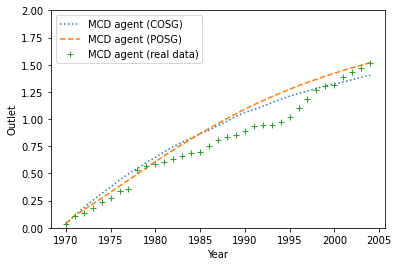

In [62]:
plt.plot(year,np.mean(ostate1_comp,axis=1),':',label='MCD agent (COSG)')
plt.plot(year,np.mean(ostate1,axis=1),'--',label='MCD agent (POSG)')
plt.plot(year,np.mean(Ni_mcd[tertile==mk].reshape([-1,35]),axis=0),'+',label='MCD agent (real data)')
plt.ylabel('Outlet')
plt.xlabel('Year')
plt.ylim(0,2)
plt.legend()
plt.show()